In [22]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool


import numpy as np
import matplotlib.pyplot as plt

plt.style.use('sg_article')
#plt.rcParams.update({"figure.figsize": (9,6)})
plt.rcParams.update({"text.usetex": True,})
plt.rcParams['legend.handlelength'] = 0


from utils import extract_cid_results, gen_conv_list

from ComputableInformationDensity.cid import interlaced_time, cid2d
from ComputableInformationDensity.computable_information_density import cid

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [23]:
def calc_time_av_ind_samples(data_arr, conv_list, unc_multiplier = 1, ddof = 1,):
    """
    data_arr must have shape (Nframes, Nsomething, Nact, Nexp)
    returns an array of shape (Nact, 2)
    """

    Nframes, Nsomething, Nact, Nexp = data_arr.shape
 
    time_av = np.nan * np.zeros((Nact, 2))
    
    for i in range(Nact):
        ff_idx = conv_list[i]

        Nsamples = np.sum(~np.isnan(data_arr[ff_idx:,:,:,:])) 
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            time_av[i, 0]  = np.nanmean(data_arr[ff_idx:, :, i, :], axis = (0, 1, -1))
            time_av[i, 1] = np.nanstd(data_arr[ff_idx:, :, i, :], axis = (0, 1, -1), ddof = ddof) / np.sqrt(Nsamples / unc_multiplier)
    return time_av

In [153]:
extract = False
calc_time_av = False
verbose = True
save_figs = False

nexp = 5
nbits = 6
cg = 4
output_suffix=f'_nb{nbits}cg{cg}'
uncertainty_multiplier = 20
act_exclude_dict = {512: [0.02, 0.0225], 1024: [], 2048: []}

L_list = [512, 1024, 2048]
figs_save_path = f'data\\nematic\\figs\\{output_suffix[1:]}'
if not os.path.exists(figs_save_path): os.makedirs(figs_save_path )

act_dict = {}
cid_time_av_dict = {}
cid_shuffle_time_av_dict = {}
frac_time_av_dict = {}

for LX in L_list:

    base_path = f'Z:\\cid\\na{LX}'
    save_path = f'data\\nematic\\na{LX}'

    if not os.path.exists(save_path):
        os.makedirs(save_path )

    

    info_dict = {'base_path': base_path,
                'save_path': save_path,
                'output_suffix': output_suffix,
                'act_exclude_list': act_exclude_dict[LX],
                'LX': LX,
                'nexp': nexp,}

    if extract:
        conv_list = np.load(os.path.join(save_path, f'conv_list.npy'), allow_pickle=True)
        extract_cid_results(info_dict, verbose=True)
        gen_conv_list(conv_list, output_suffix, save_path)

    with open(os.path.join(save_path, f'cid_params{output_suffix}.pkl'), 'rb') as f:
                    cid_params = pkl.load(f)

    ncubes = cid_params['ncubes']
    npartitions = cid_params['npartitions']

    data_npz = np.load(os.path.join(save_path, f'cid_data{output_suffix}.npz'), allow_pickle=True)
    cid_arr = data_npz['cid']
    cid_shuffle_arr = data_npz['cid_shuffle']
    cid_frac_arr = data_npz['cid_frac']
    act_list = data_npz['act_list']
    conv_list = np.load(os.path.join(save_path, f'conv_list_cubes{output_suffix}.npy'), allow_pickle=True)

    if calc_time_av:
        cid_time_av = calc_time_av_ind_samples(cid_arr[:,:,:,:,0], conv_list, unc_multiplier=uncertainty_multiplier)
        cid_shuffle_time_av = calc_time_av_ind_samples(cid_shuffle_arr[:,:,:,:,0], conv_list, unc_multiplier=uncertainty_multiplier)
        cid_frac_time_av = calc_time_av_ind_samples(cid_frac_arr[:,:,:,:,0], conv_list, unc_multiplier=uncertainty_multiplier)

        np.savez_compressed(os.path.join(save_path, f'cid_time_av{output_suffix}.npz'),
                            cid_time_av=cid_time_av,
                            cid_shuffle_time_av=cid_shuffle_time_av,
                            cid_frac_time_av=cid_frac_time_av,
                            act_list=act_list,
                            )
    else:
        time_av_npz = np.load(os.path.join(save_path, f'cid_time_av{output_suffix}.npz'), allow_pickle=True)
        cid_time_av = time_av_npz['cid_time_av']
        cid_shuffle_time_av = time_av_npz['cid_shuffle_time_av']
        cid_frac_time_av = time_av_npz['cid_frac_time_av']
        act_list = time_av_npz['act_list']

    act_dict[LX] = act_list
    cid_time_av_dict[LX] = cid_time_av
    cid_shuffle_time_av_dict[LX] = cid_shuffle_time_av
    frac_time_av_dict[LX] = cid_frac_time_av


TODO:

- would be pretty to have results for nbits=3,4,7
- we need to show inv under cg = 4 --> 2

- how changeths under window size?
- calc var X and varX / X for cid, div. Comp to dXdzeta


- we need cid and deriv_cid + var cid + var cid / cid!!


CONSIDER: maybe exp_av should be taken AFTER all analyses of each series. otherwise
          we are obscuring patterns and interactings immediately´
... also: consider that it is not useful for eg the cid-grid.
--> think you a little about
- account for conv_list
- we need 3 avs for frac array
... do both weighted and no
... temp corr account for 

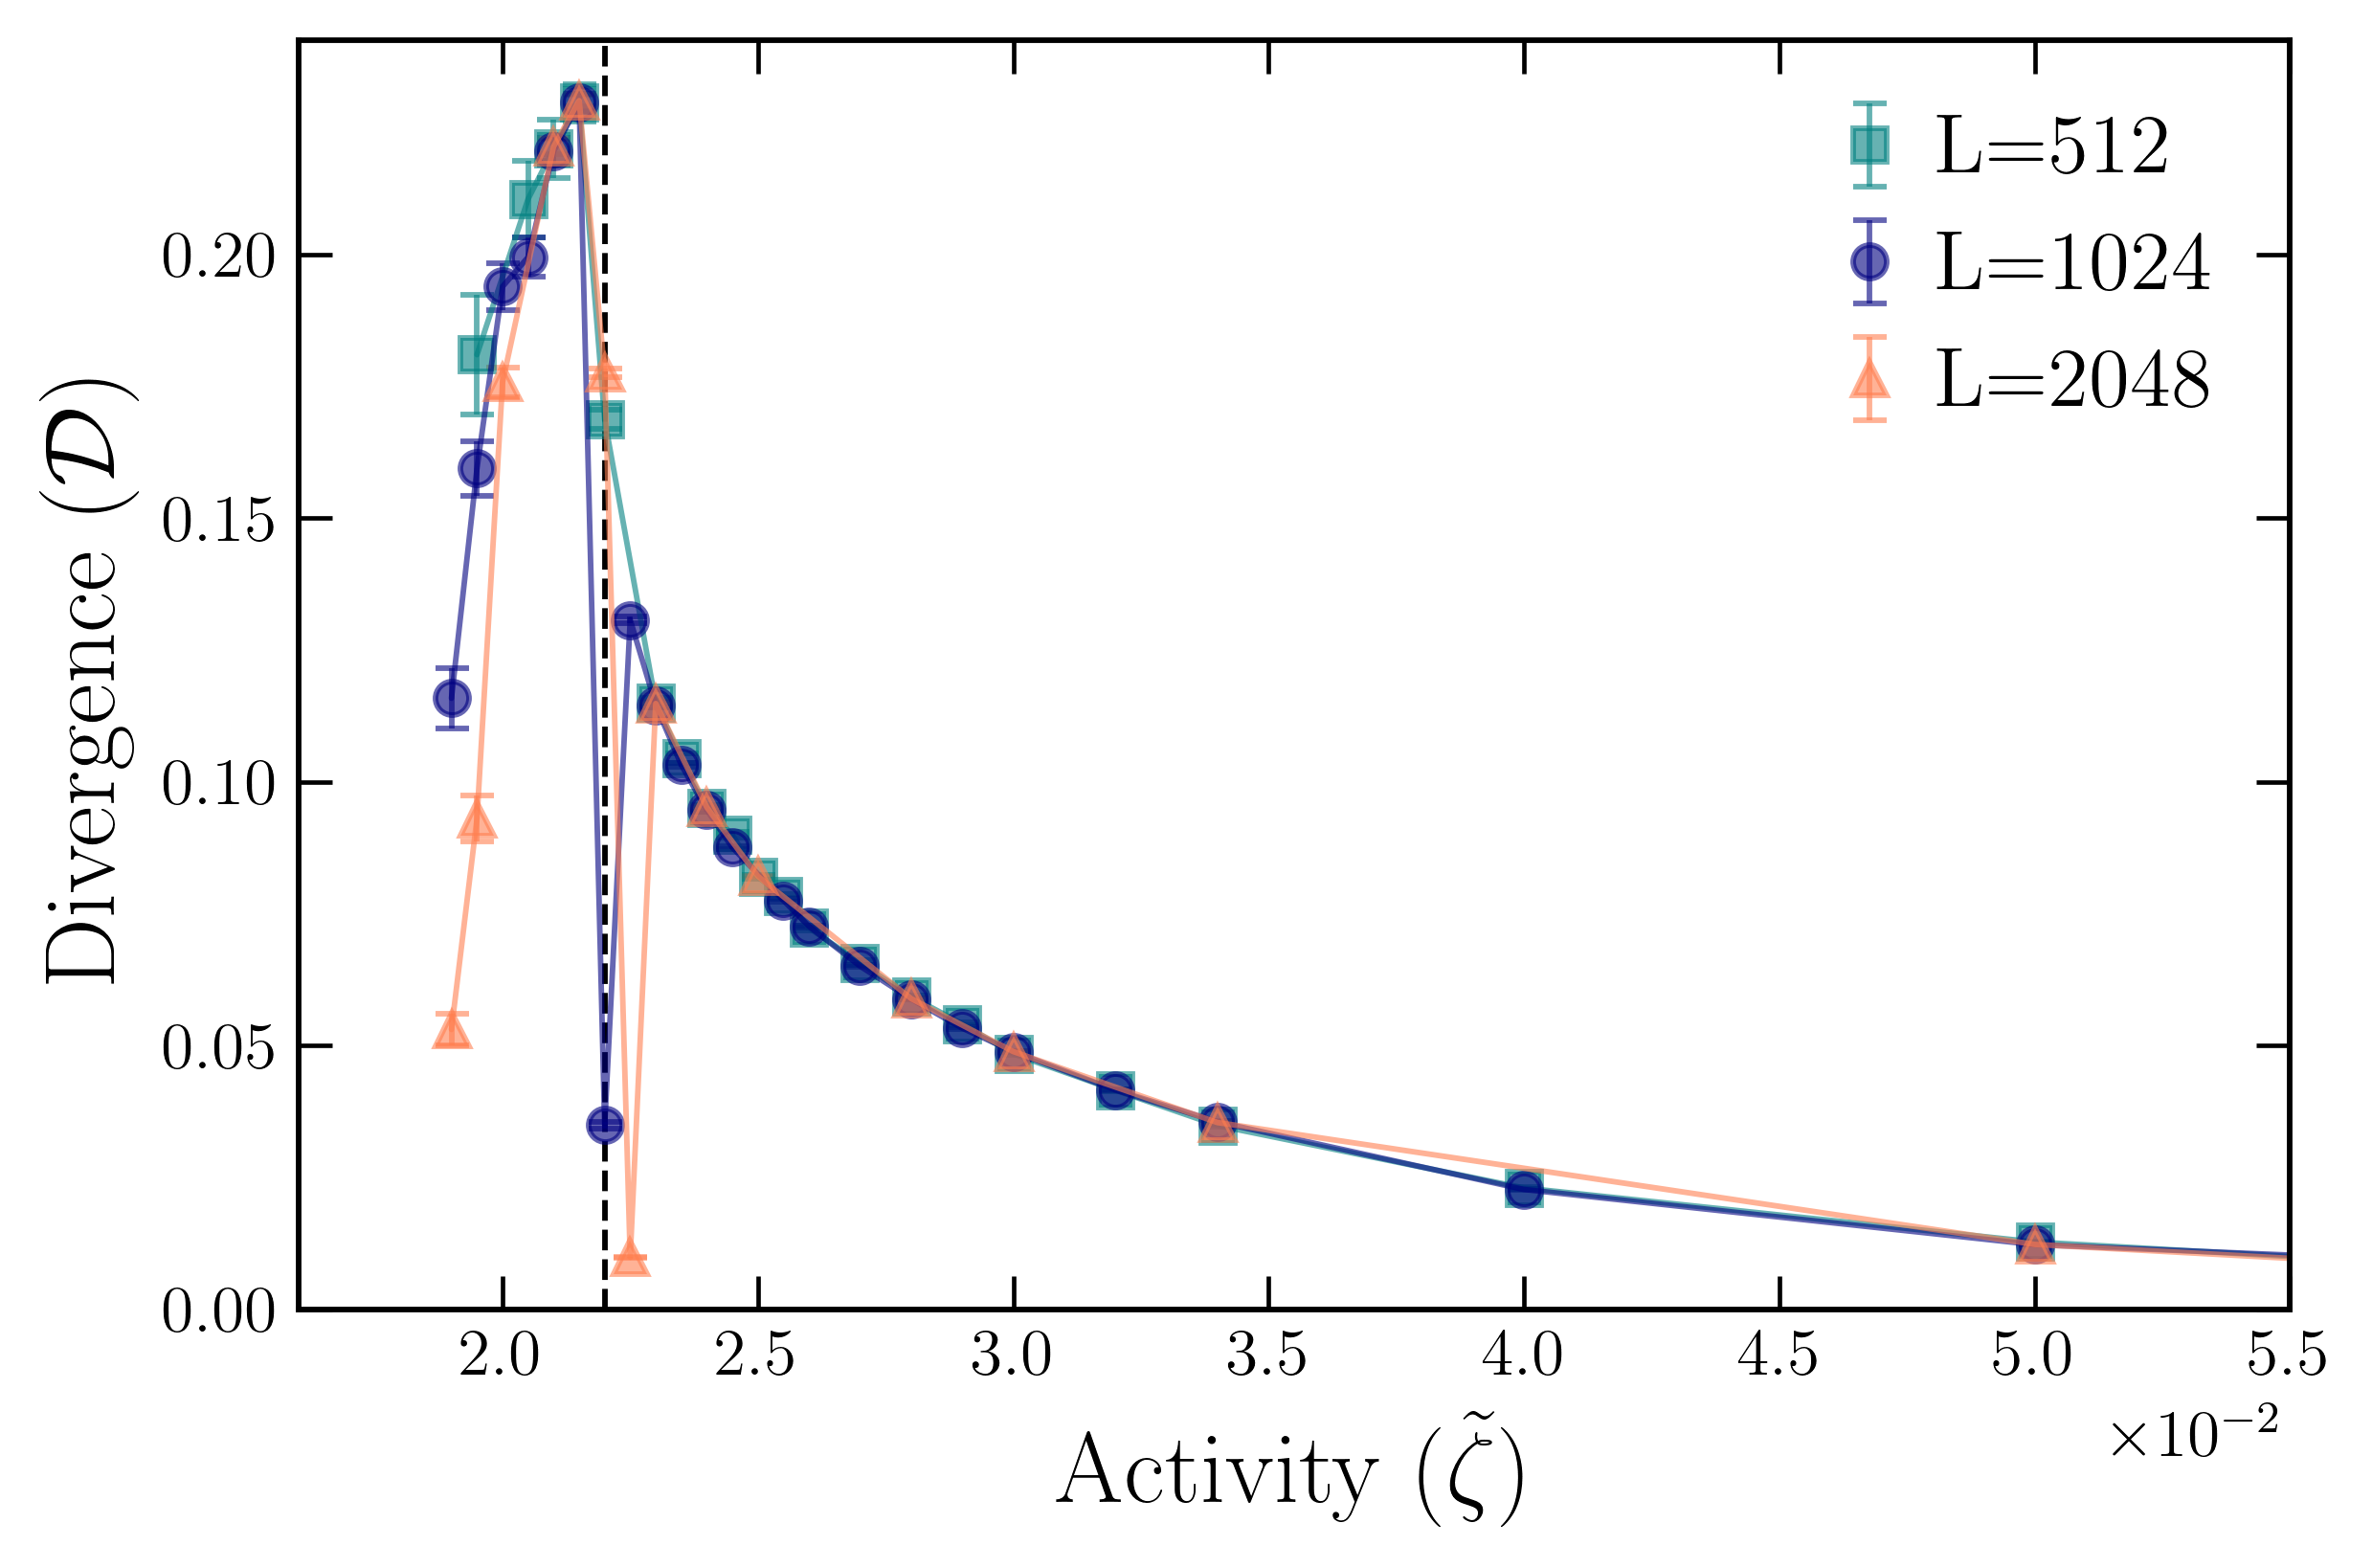

In [ ]:
### Plot frac_av vs activity for different system sizes
fig, ax = plt.subplots(figsize=(6,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
plot_div = True

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    yvals = 1 - cid_frac_time_av[:,0] if plot_div else cid_frac_time_av[:,0]

    ax.errorbar(act_list, yvals, yerr=cid_frac_time_av[:,1], fmt=marker_shape[i], lw=1, label=f'L={LX}', capsize=3, alpha=.6)

ax.vlines(0.022, 0, np.nanmax(yvals*1.05), color='k', linestyle='--', lw=1, zorder=-5)
ax.set_xlim(0.016, 0.055)
ax.set_ylim(0, np.nanmax(yvals*1.05))
#ax.set_ylim(np.nanmin(cid_frac_time_av[:,0]*0.95), np.nanmax(cid_frac_time_av[:,0]*1.05))
ax.set_xlabel(r'Activity ($\tilde{\zeta}$)')
ylabel = r'Divergence ($\mathcal{D}$)' if plot_div else r'CID/CID$_\mathrm{shuffle}$)'
ax.set_ylabel(ylabel) #CID/CID$_\mathrm{shuffle}
ax.legend()#loc='lower right')

if save_figs:
    fig.savefig(os.path.join(figs_save_path, f'av_div.pdf'),bbox_inches='tight', dpi=620, pad_inches=.05)

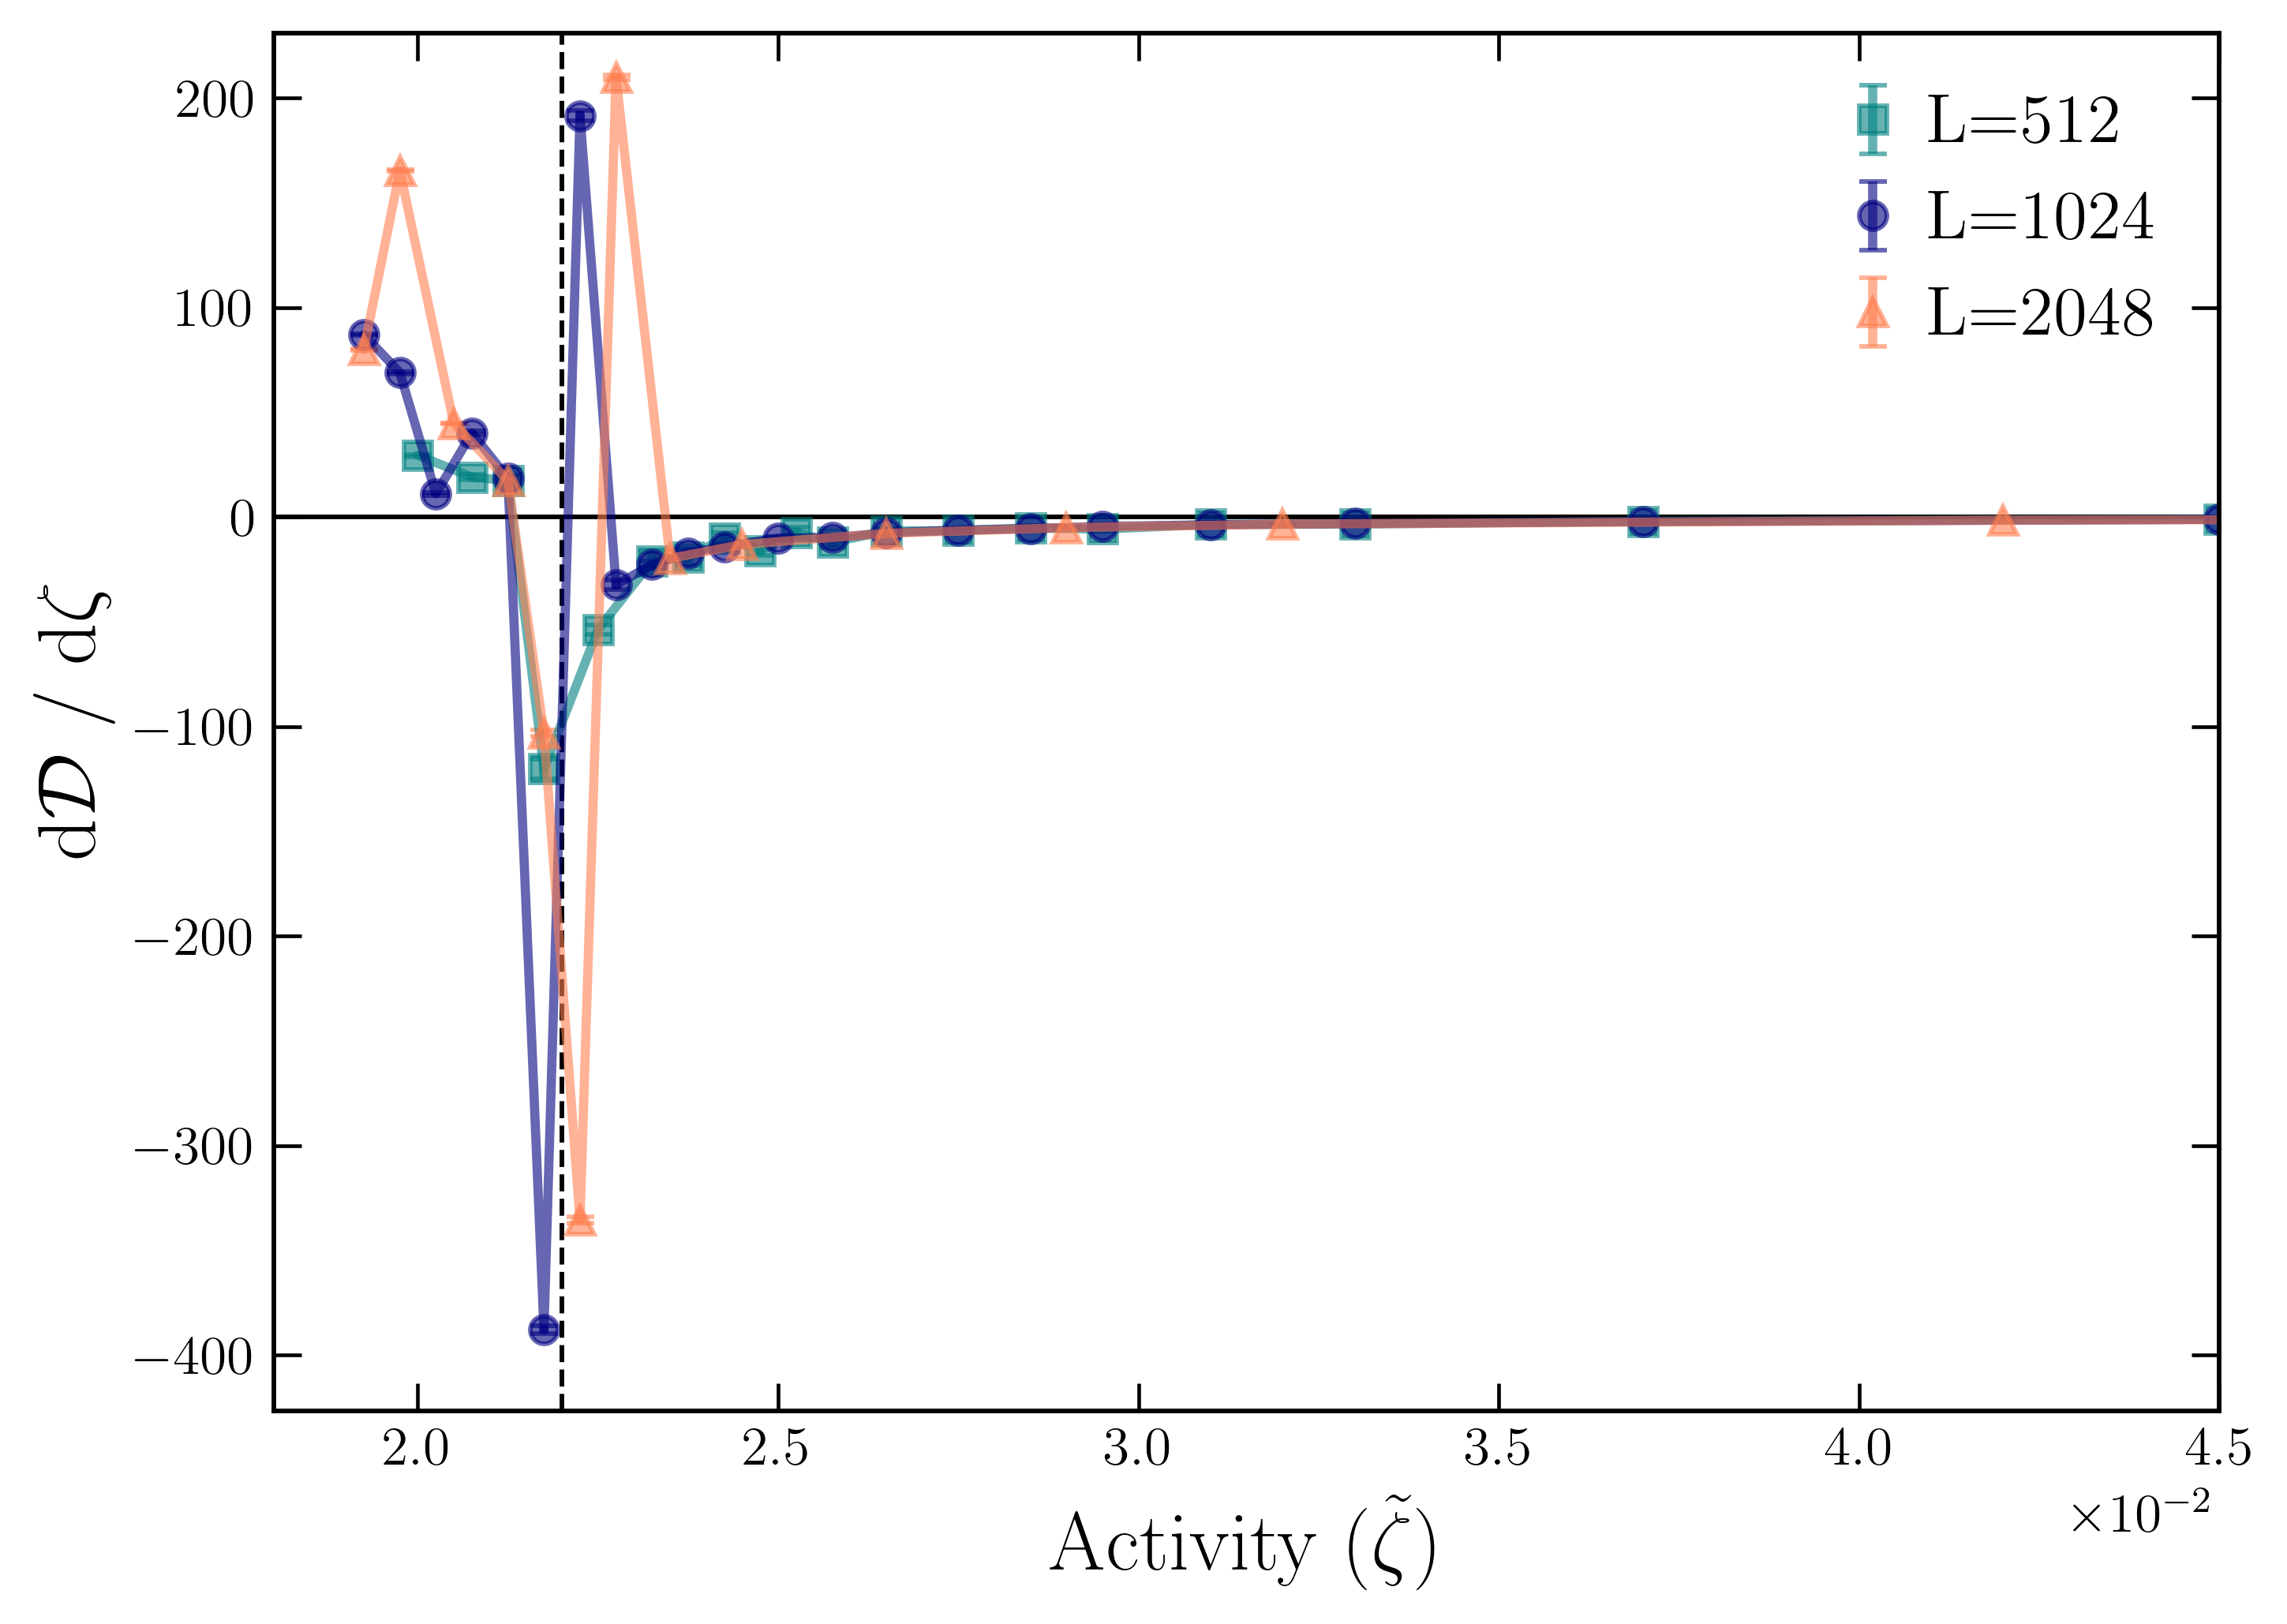

In [ ]:
### Plot frac_deriv vs activity for different system sizes
fig, ax = plt.subplots(figsize=(7,5))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
plot_abs = False

ymin, ymax = 0, 0

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    frac_diff = np.diff(1 - cid_frac_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_frac = frac_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_cid_err = np.sqrt(cid_time_av[:, 1][1:]**2 + cid_time_av[:,1][:-1]**2) / act_diff

    yvals = np.abs(deriv_frac) if plot_abs else deriv_frac
    ax.errorbar(act_diff_tot, yvals, yerr=deriv_cid_err, fmt=marker_shape[i], label=f'L={LX}', capsize=3, alpha=.6)

    ymin = min(ymin, np.nanmin(yvals))
    ymax = max(ymax, np.nanmax(yvals))

ax.vlines(0.022, ymin*1.1, ymax*1.1, color='k', linestyle='--', lw=1,)
ax.hlines(0, 0, .1, color='k', linestyle='-', lw=1,)
ax.set_xlim(0.018, 0.045)
ax.set_ylim(ymin*1.1, ymax*1.1)
ax.set_xlabel(r'Activity ($\tilde{\zeta}$)')
ax.set_ylabel(r'd$\mathcal{D}$ / d$\zeta$')
ax.legend(ncols=1, loc='upper right')

if save_figs:   
    fig.savefig(os.path.join(figs_save_path, f'ddiv.pdf'), bbox_inches='tight', dpi=620, pad_inches=.05)

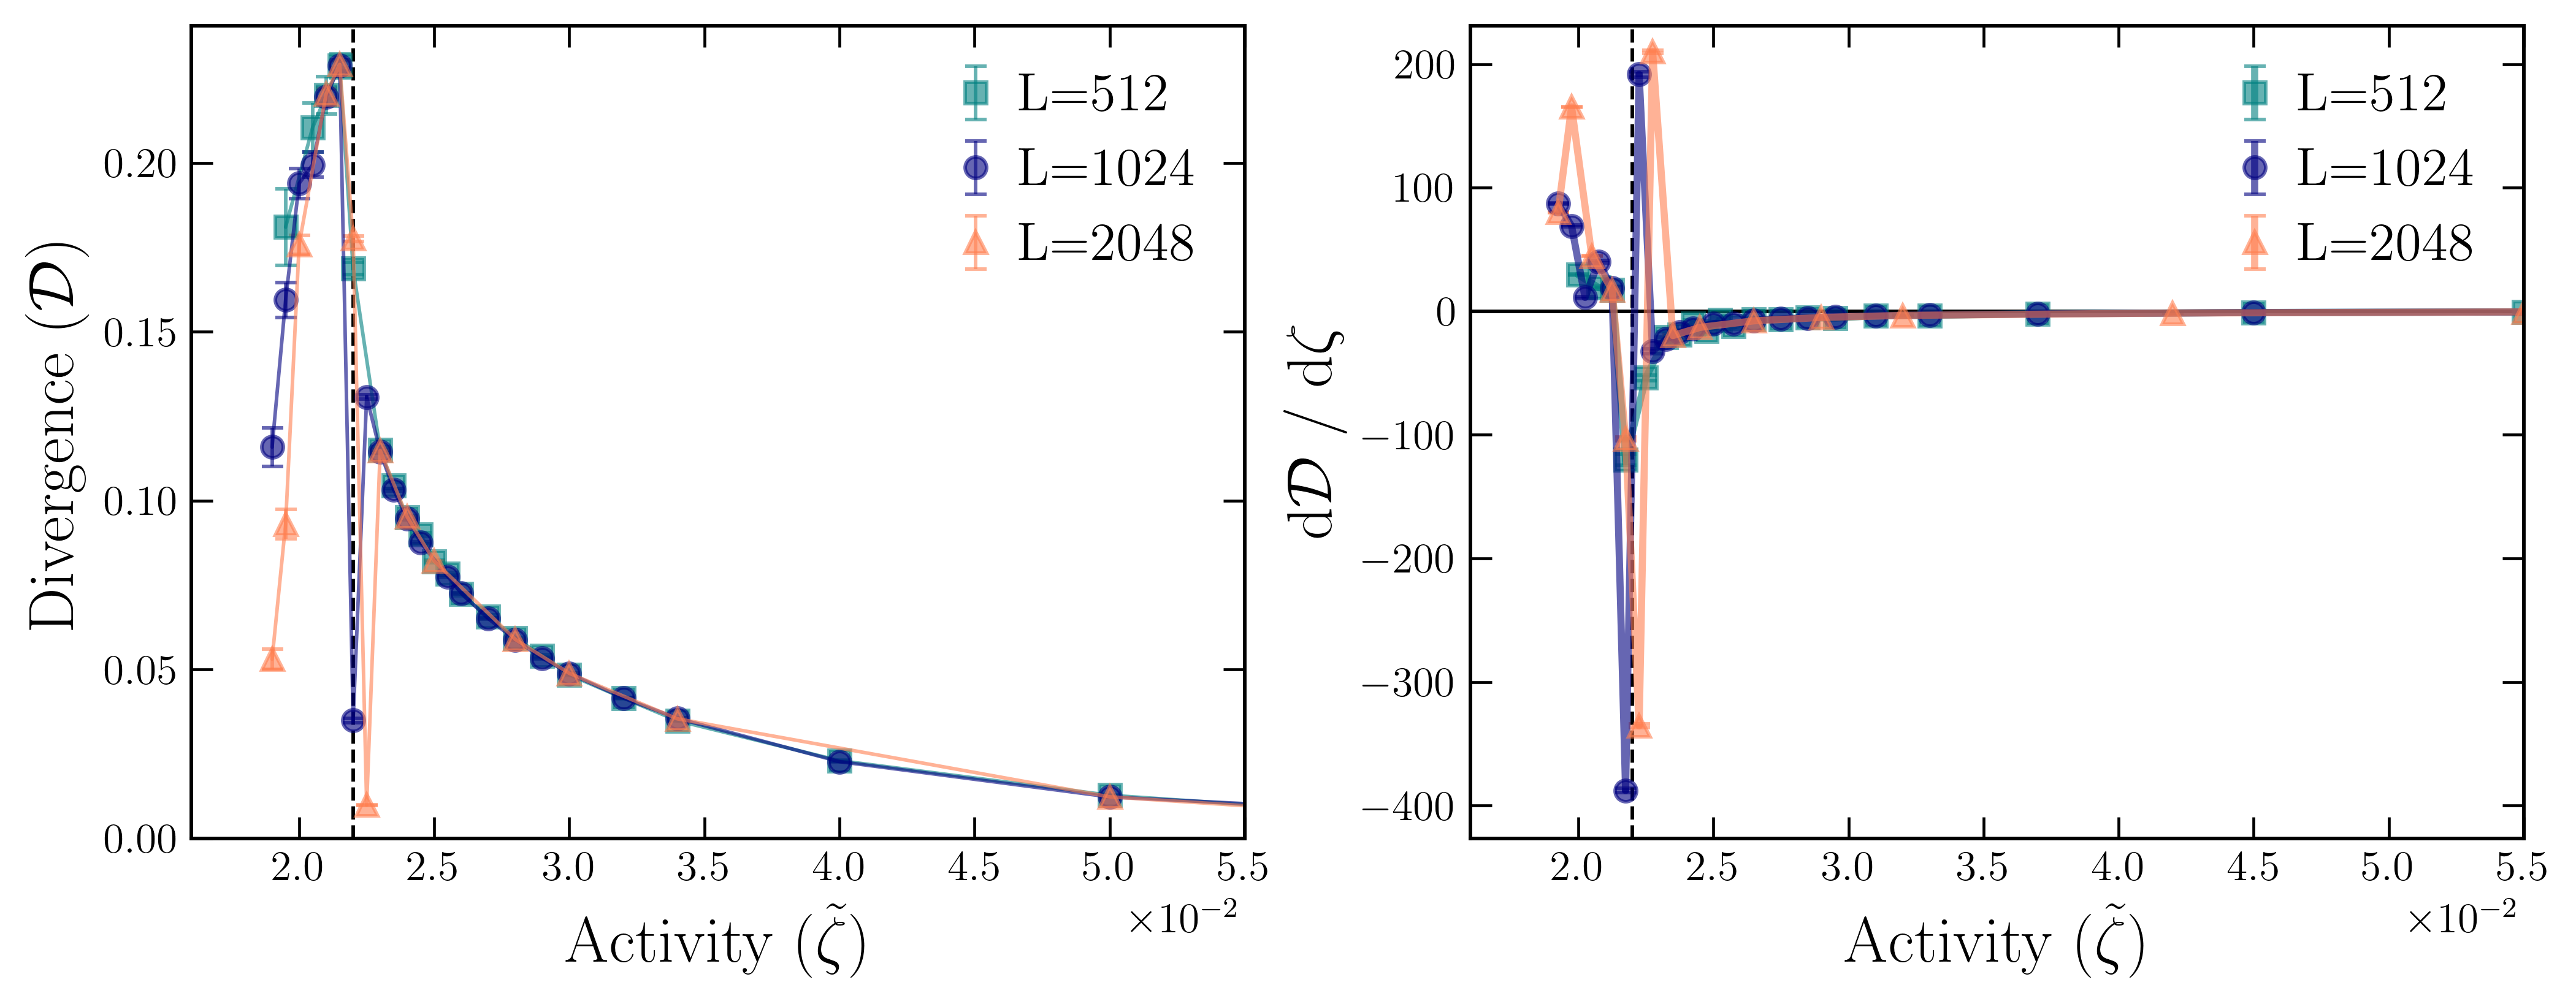

In [ ]:
### Plot cid_av vs activity for different system sizes
fig, ax0 = plt.subplots(ncols=2, figsize=(10,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
ax = ax0[0]
axx = ax0[1]

plot_div = True
plot_abs = False

xlim = (0.016, 0.055)
ymin, ymax = 0, 0

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    frac_diff = np.diff(1 - cid_frac_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_frac = frac_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_cid_err = np.sqrt(cid_time_av[:, 1][1:]**2 + cid_time_av[:,1][:-1]**2) / act_diff

    yvals = 1 - cid_frac_time_av[:,0] if plot_div else cid_frac_time_av[:,0]
    frac_yvals = np.abs(deriv_frac) if plot_abs else deriv_frac

    ax.errorbar(act_list, yvals, yerr=cid_frac_time_av[:,1], fmt=marker_shape[i], lw=1, label=f'L={LX}', capsize=3, alpha=.6)
    axx.errorbar(act_diff_tot, frac_yvals, yerr=deriv_cid_err, fmt=marker_shape[i], label=f'L={LX}', capsize=3, alpha=.6)

    ymin = min(ymin, np.nanmin(frac_yvals))
    ymax = max(ymax, np.nanmax(frac_yvals))

ax.vlines(0.022, 0, np.nanmax(yvals*1.05), color='k', linestyle='--', lw=1, zorder=-5)
ax.set_ylim(0, np.nanmax(yvals*1.05))

ylabel = r'Divergence ($\mathcal{D}$)' if plot_div else r'CID/CID$_\mathrm{shuffle}$)'
ax.set_ylabel(ylabel) #
ax.legend()

axx.vlines(0.022, ymin*1.1, ymax*1.1, color='k', linestyle='--', lw=1,)
axx.hlines(0, 0, .1, color='k', linestyle='-', lw=1,)
axx.set_ylim(ymin*1.1, ymax*1.1)
axx.set_ylabel(r'd$\mathcal{D}$ / d$\zeta$')
axx.legend(ncols=1, loc='upper right')

for i in range(2):
    ax0[i].set_xlim(xlim)
  #  ax0[i].vlines(0.022, 0, np.nanmax(deriv_cid*1.1), color='k', linestyle='--', lw=1,)
    ax0[i].set_xlabel(r'Activity ($\tilde{\zeta}$)')

if save_figs:
  fig.savefig(os.path.join(figs_save_path, f'div_ddiv.pdf') ,bbox_inches='tight', dpi=620, pad_inches=.05)

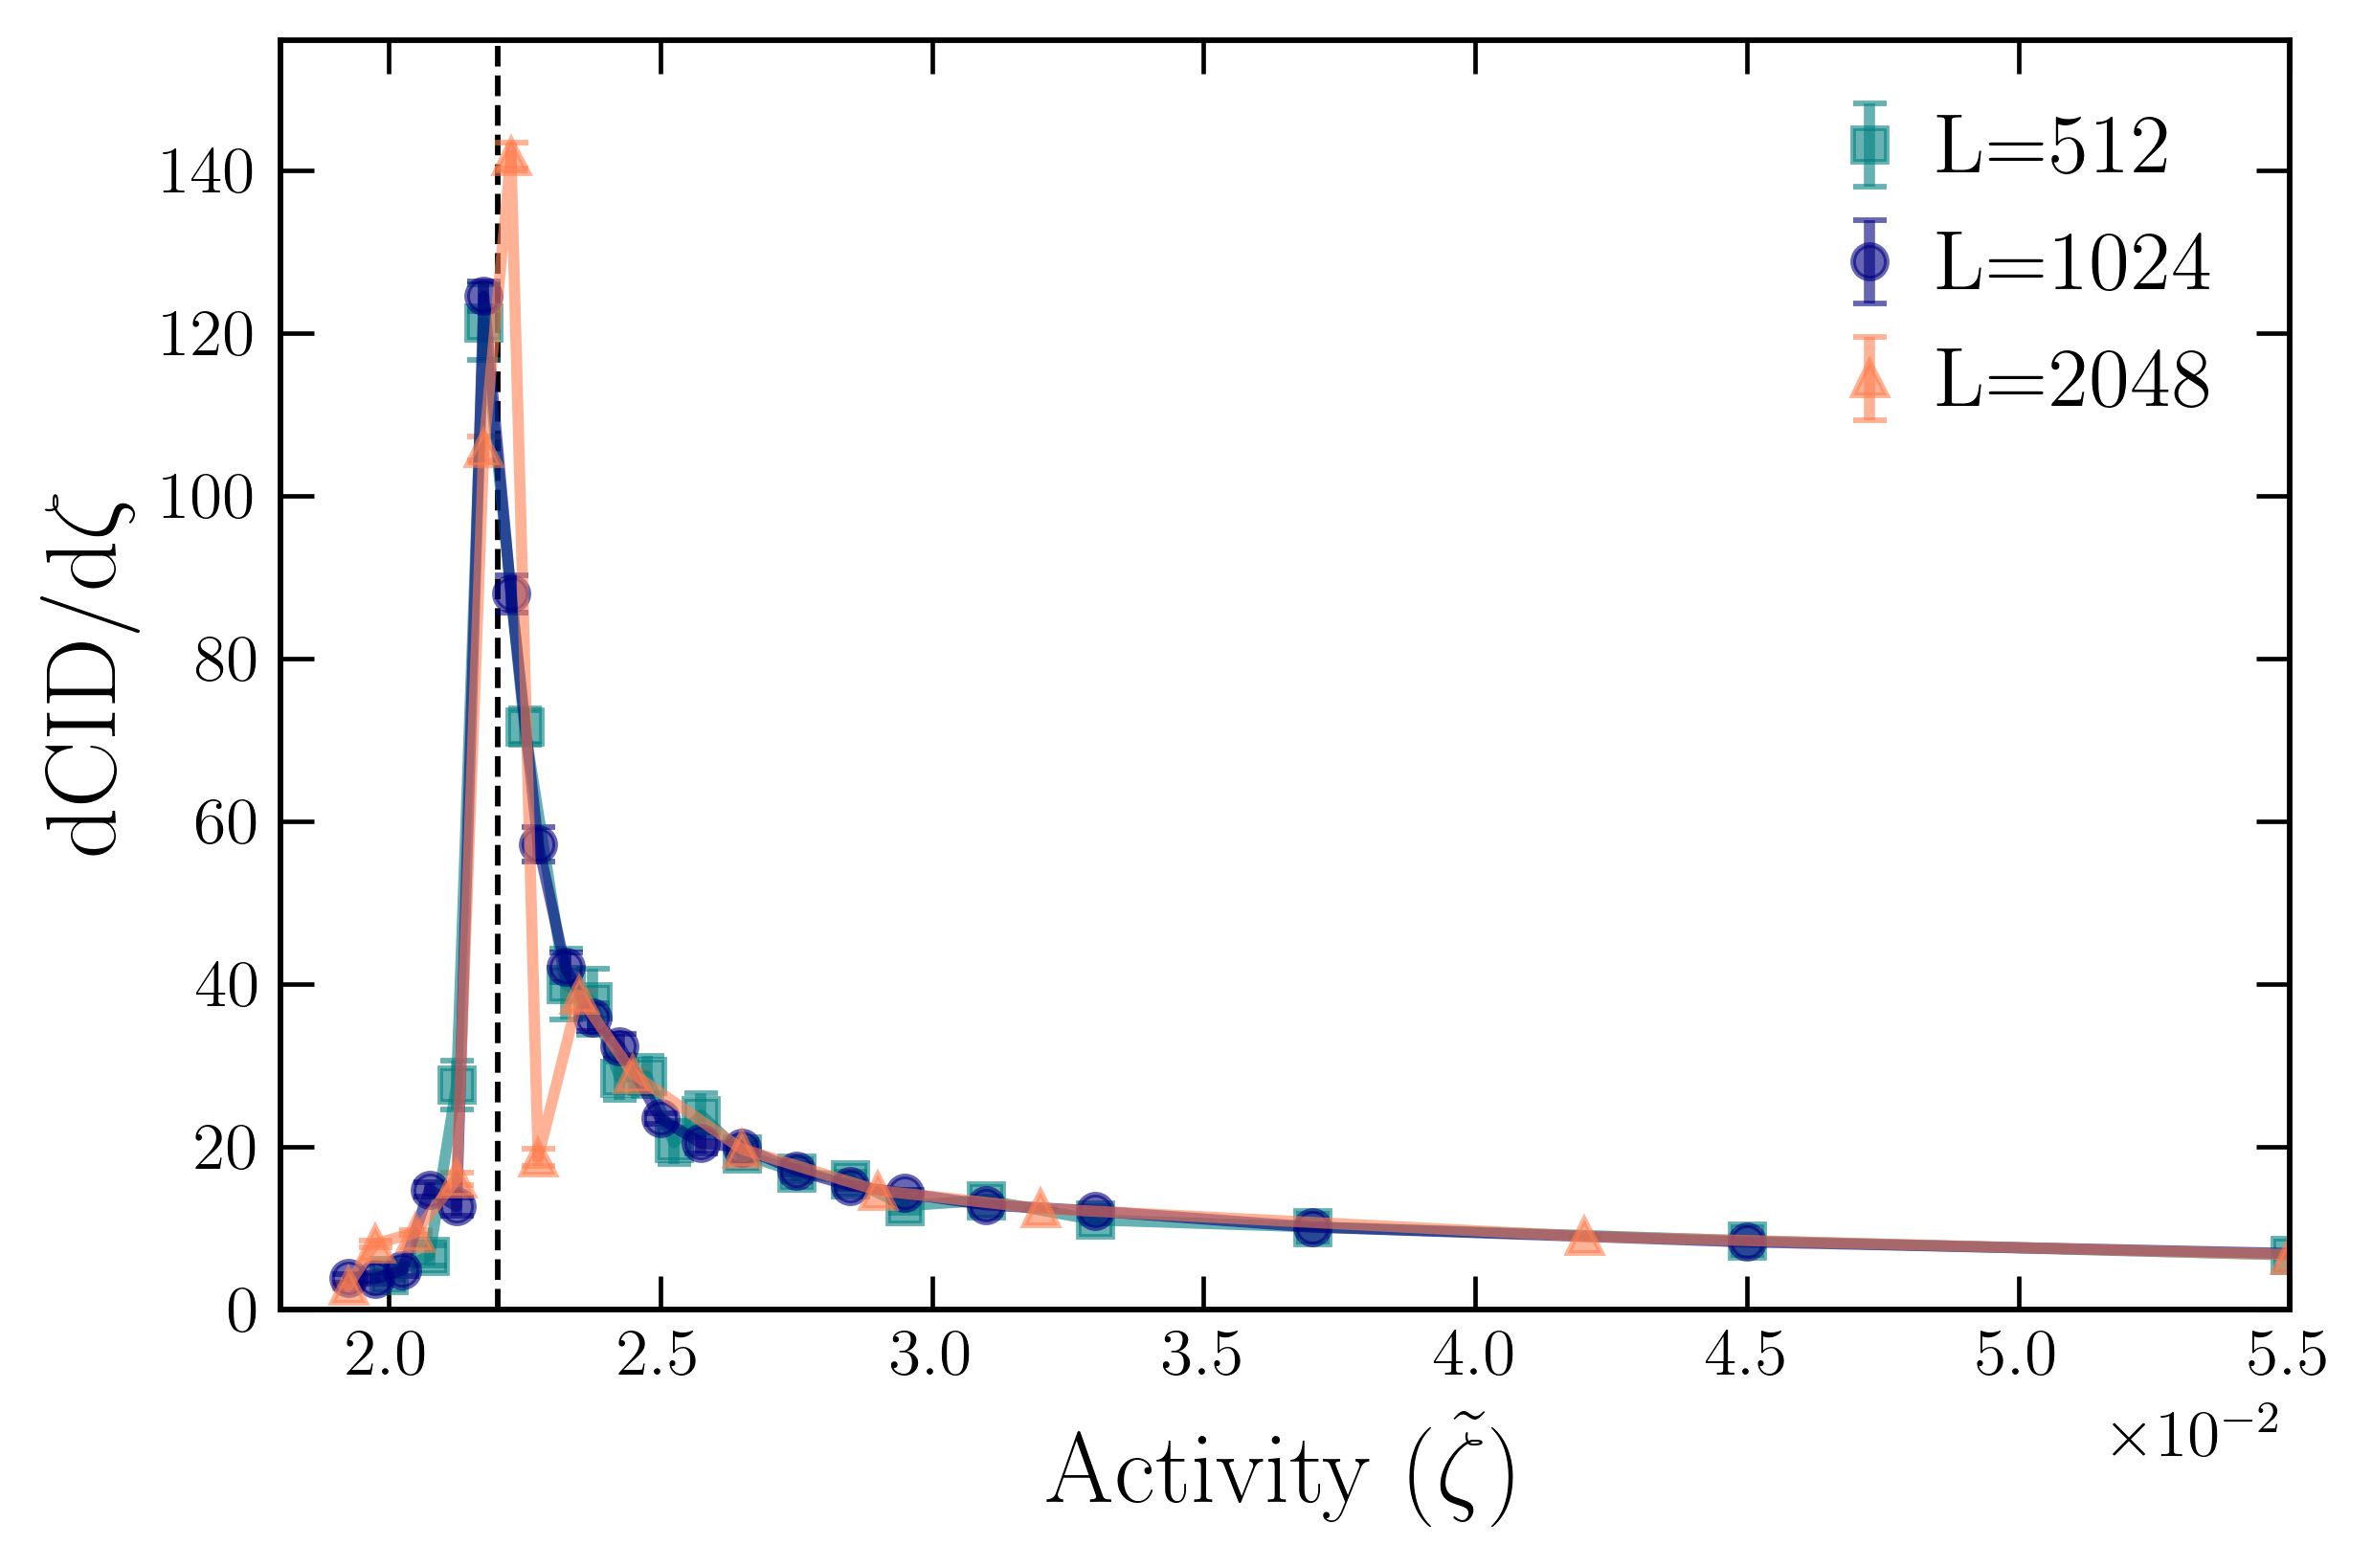

In [ ]:
### Plot cid_deriv vs activity for different system sizes
fig, ax = plt.subplots(figsize=(6,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    cid_diff = np.diff(cid_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_cid = cid_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_cid_err = np.sqrt(cid_time_av[:, 1][1:]**2 + cid_time_av[:,1][:-1]**2) / act_diff

    ax.errorbar(act_diff_tot, deriv_cid, yerr=deriv_cid_err, fmt=marker_shape[i], label=f'L={LX}', capsize=3, alpha=.6)

ax.vlines(0.022, 0, np.nanmax(deriv_cid*1.1), color='k', linestyle='--', lw=1, zorder=-5)
ax.hlines(0, 0, .1, color='k', linestyle='-', lw=1,)
ax.set_xlim(0.018, 0.055)
ax.set_ylim(ymin=0, ymax=np.nanmax(deriv_cid*1.1))
ax.set_xlabel(r'Activity ($\tilde{\zeta}$)')
ax.set_ylabel(r'dCID/d$\zeta$')
ax.legend(ncols=1, loc='upper right')

if save_figs:
    fig.savefig(os.path.join(figs_save_path, f'dCID.pdf'), bbox_inches='tight', dpi=620, pad_inches=.05)


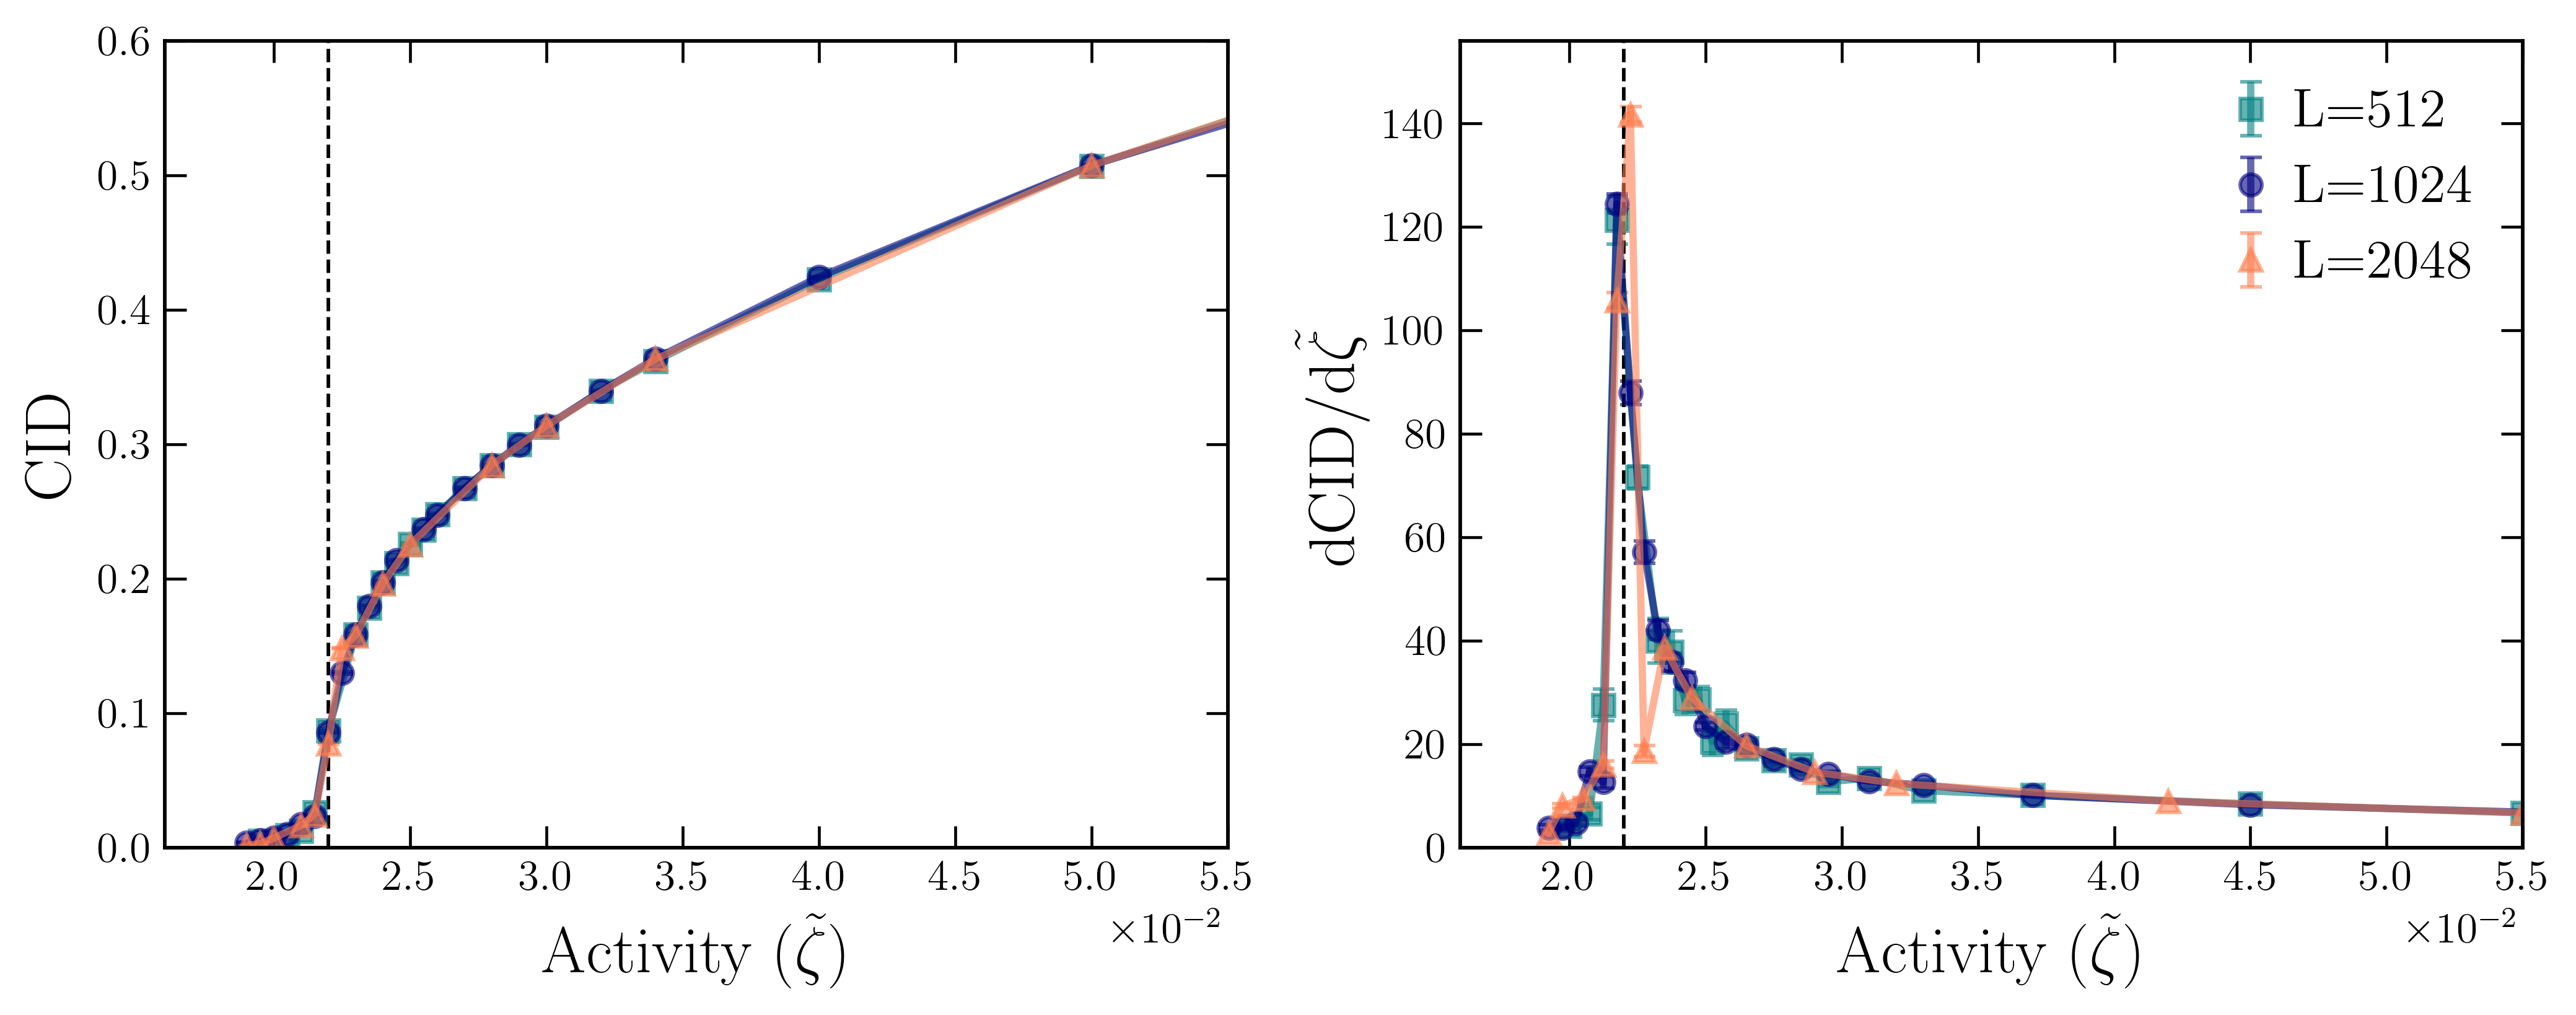

In [ ]:
### Plot cid_av vs activity for different system sizes
fig, ax0 = plt.subplots(ncols=2, figsize=(10,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

xlim = (0.016, 0.055)
ax = ax0[0]
axx = ax0[1]

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    cid_diff = np.diff(cid_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_cid = cid_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_cid_err = np.sqrt(cid_time_av[:, 1][1:]**2 + cid_time_av[:,1][:-1]**2) / act_diff

    ax.errorbar(act_list, cid_time_av[:,0], yerr=cid_time_av[:,1], fmt=marker_shape[i], label=f'L={LX}', capsize=3, alpha=.6)
    axx.errorbar(act_diff_tot, deriv_cid, yerr=deriv_cid_err, fmt=marker_shape[i], label=f'L={LX}', capsize=3, alpha=.6)

for i in range(2):
    ax0[i].set_xlim(xlim)
    ax0[i].vlines(0.022, 0, np.nanmax(deriv_cid*1.1), color='k', linestyle='--', lw=1,)
    ax0[i].set_xlabel(r'Activity ($\tilde{\zeta}$)')

ax.set_ylim(0, 0.6)
ax.set_ylabel(r'CID')
axx.set_ylim(0, np.nanmax(deriv_cid*1.1))
axx.set_ylabel(r'dCID/d$\tilde{\zeta}$')
axx.legend(ncols=1, loc='upper right')

if save_figs:
    fig.savefig(os.path.join(figs_save_path, f'cid_dcid.pdf'), \
                bbox_inches='tight', dpi=620, pad_inches=.05)

In [ ]:
frac_exp_avw = np.nan * np.zeros((ncubes, npartitions, len(act_list), 2))
frac_savw = np.nan * np.zeros((ncubes, len(act_list), 2))
frac_tavw = np.nan * np.zeros((npartitions, len(act_list), 2))
frac_avw = np.nan * np.zeros((len(act_list), 2))

frac_exp_av = np.nan * np.zeros((ncubes, npartitions, len(act_list), 2))
frac_sav = np.nan * np.zeros((ncubes, len(act_list), 2))
frac_tav = np.nan * np.zeros((npartitions, len(act_list), 2))
frac_av = np.nan * np.zeros((len(act_list), 2))
cid_av = np.nan * np.zeros((len(act_list), 2))
cid_shuffle_av = np.nan * np.zeros((len(act_list), 2))

frac_exp_av[:, :, :, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=3)
frac_exp_av[:, :, :, 1] = np.nanstd(cid_frac_arr[:,:,:,:,0], axis=3) / np.sqrt(np.sum(~np.isnan(cid_frac_arr[:,:,:,:,0]), axis=3))
frac_sav[:, :, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=(1,3))
frac_sav[:, :, 1] = np.nanstd(cid_frac_arr[:,:,:,:,0], axis=(1,3)) / np.sqrt(np.sum(~np.isnan(cid_frac_arr[:,:,:,:,0]), axis=(1,3)))
frac_tav[:, :, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=(0,3))
frac_tav[:, :, 1] = np.nanstd(cid_frac_arr[:,:,:,:,0], axis=(0,3)) / np.sqrt(np.sum(~np.isnan(cid_frac_arr[:,:,:,:,0]), axis=(0,3)))
frac_av[:, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=(0,1,3))
frac_av[:, 1] = np.nanstd(cid_frac_arr[:,:,:,:,0], axis=(0,1,3)) / np.sqrt(np.sum(~np.isnan(cid_frac_arr[:,:,:,:,0]), axis=(0,1,3)))
cid_av[:, 0] = np.nanmean(cid_arr[:,:,:,:,0], axis=(0,1,3))
cid_av[:, 1] = np.nanstd(cid_arr[:,:,:,:,0], axis=(0,1,3)) / np.sqrt(np.sum(~np.isnan(cid_arr[:,:,:,:,0]), axis=(0,1,3)))
cid_shuffle_av[:, 0] = np.nanmean(cid_shuffle_arr[:,:,:,:,0], axis=(0,1,3))
cid_shuffle_av[:, 1] = np.nanstd(cid_shuffle_arr[:,:,:,:,0], axis=(0,1,3)) / np.sqrt(np.sum(~np.isnan(cid_shuffle_arr[:,:,:,:,0]), axis=(0,1,3)))

frac_exp_avw[:, :, :, 0], frac_exp_avw[:, :, :, 1] = calc_weighted_mean(cid_frac_arr[:, :, :, :, 0] , cid_frac_arr[:, :, :, :, 1], axis=-1, omit_null_uncertainties=True)
frac_savw[:, :, 0], frac_savw[:, :, 1] = calc_weighted_mean(frac_exp_av[:, :, :, 0], frac_exp_av[:, :, :, 1], axis=1, omit_null_uncertainties=True)
frac_tavw[:, :, 0], frac_tavw[:, :, 1] = calc_weighted_mean(frac_exp_av[:, :, :, 0], frac_exp_av[:, :, :, 1], axis=0, omit_null_uncertainties=True)
frac_avw[:, 0], frac_avw[:, 1] = calc_weighted_mean(frac_exp_av[:, :, :, 0], frac_exp_av[:, :, :, 1], axis=(0,1), omit_null_uncertainties=True)
#frac_avw[:, 0], frac_avw[:, 1] = calc_weighted_mean(cid_frac_arr[:,:,:,:,0], cid_frac_arr[:,:,:,:,1], axis=(0,1,3), omit_null_uncertainties=True)
#frac_exp_av[:, :, :, 0] = frac_exp_avw[0]
#frac_exp_av[:, :, :, 1] = frac_exp_avw[1]
np.isnan(frac_exp_avw[-5:, :, :, 0]).sum() / frac_exp_avw[-5:, :, :, 0].size
np.isnan(frac_savw[-5:, :, 0]).sum() / frac_savw[-5:, :, 0].size

In [ ]:
for num_exp in range(nexp):
    plt.plot(range(ncubes), np.nanmean(cid_frac_arr[:,:,act_idx,num_exp,0], axis=1), label=f'Exp {num_exp}')
plt.plot(range(ncubes), frac_sav[:,act_idx,0],'x', label=f'av')
plt.plot(range(ncubes), frac_savw[:,act_idx,0],'d', label=f'avw')
plt.legend()

In [ ]:
idx=4
#plt.hist(cid_arr[:,:,act_idx,idx,0].flatten(), bins=100, range=(0,0.2), alpha=.3);
#plt.hist(cid_shuffle_arr[:,:,act_idx,idx,0].flatten(), bins=100, range=(0,0.2), alpha=.3);
plt.hist(cid_frac_arr[:,:,act_idx,idx,1].flatten(), bins=100, alpha=.3);

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_6376\2061086159.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  simp_var = np.nanvar(cid_arr[:,:,:,:,0], axis=(0,1,3))


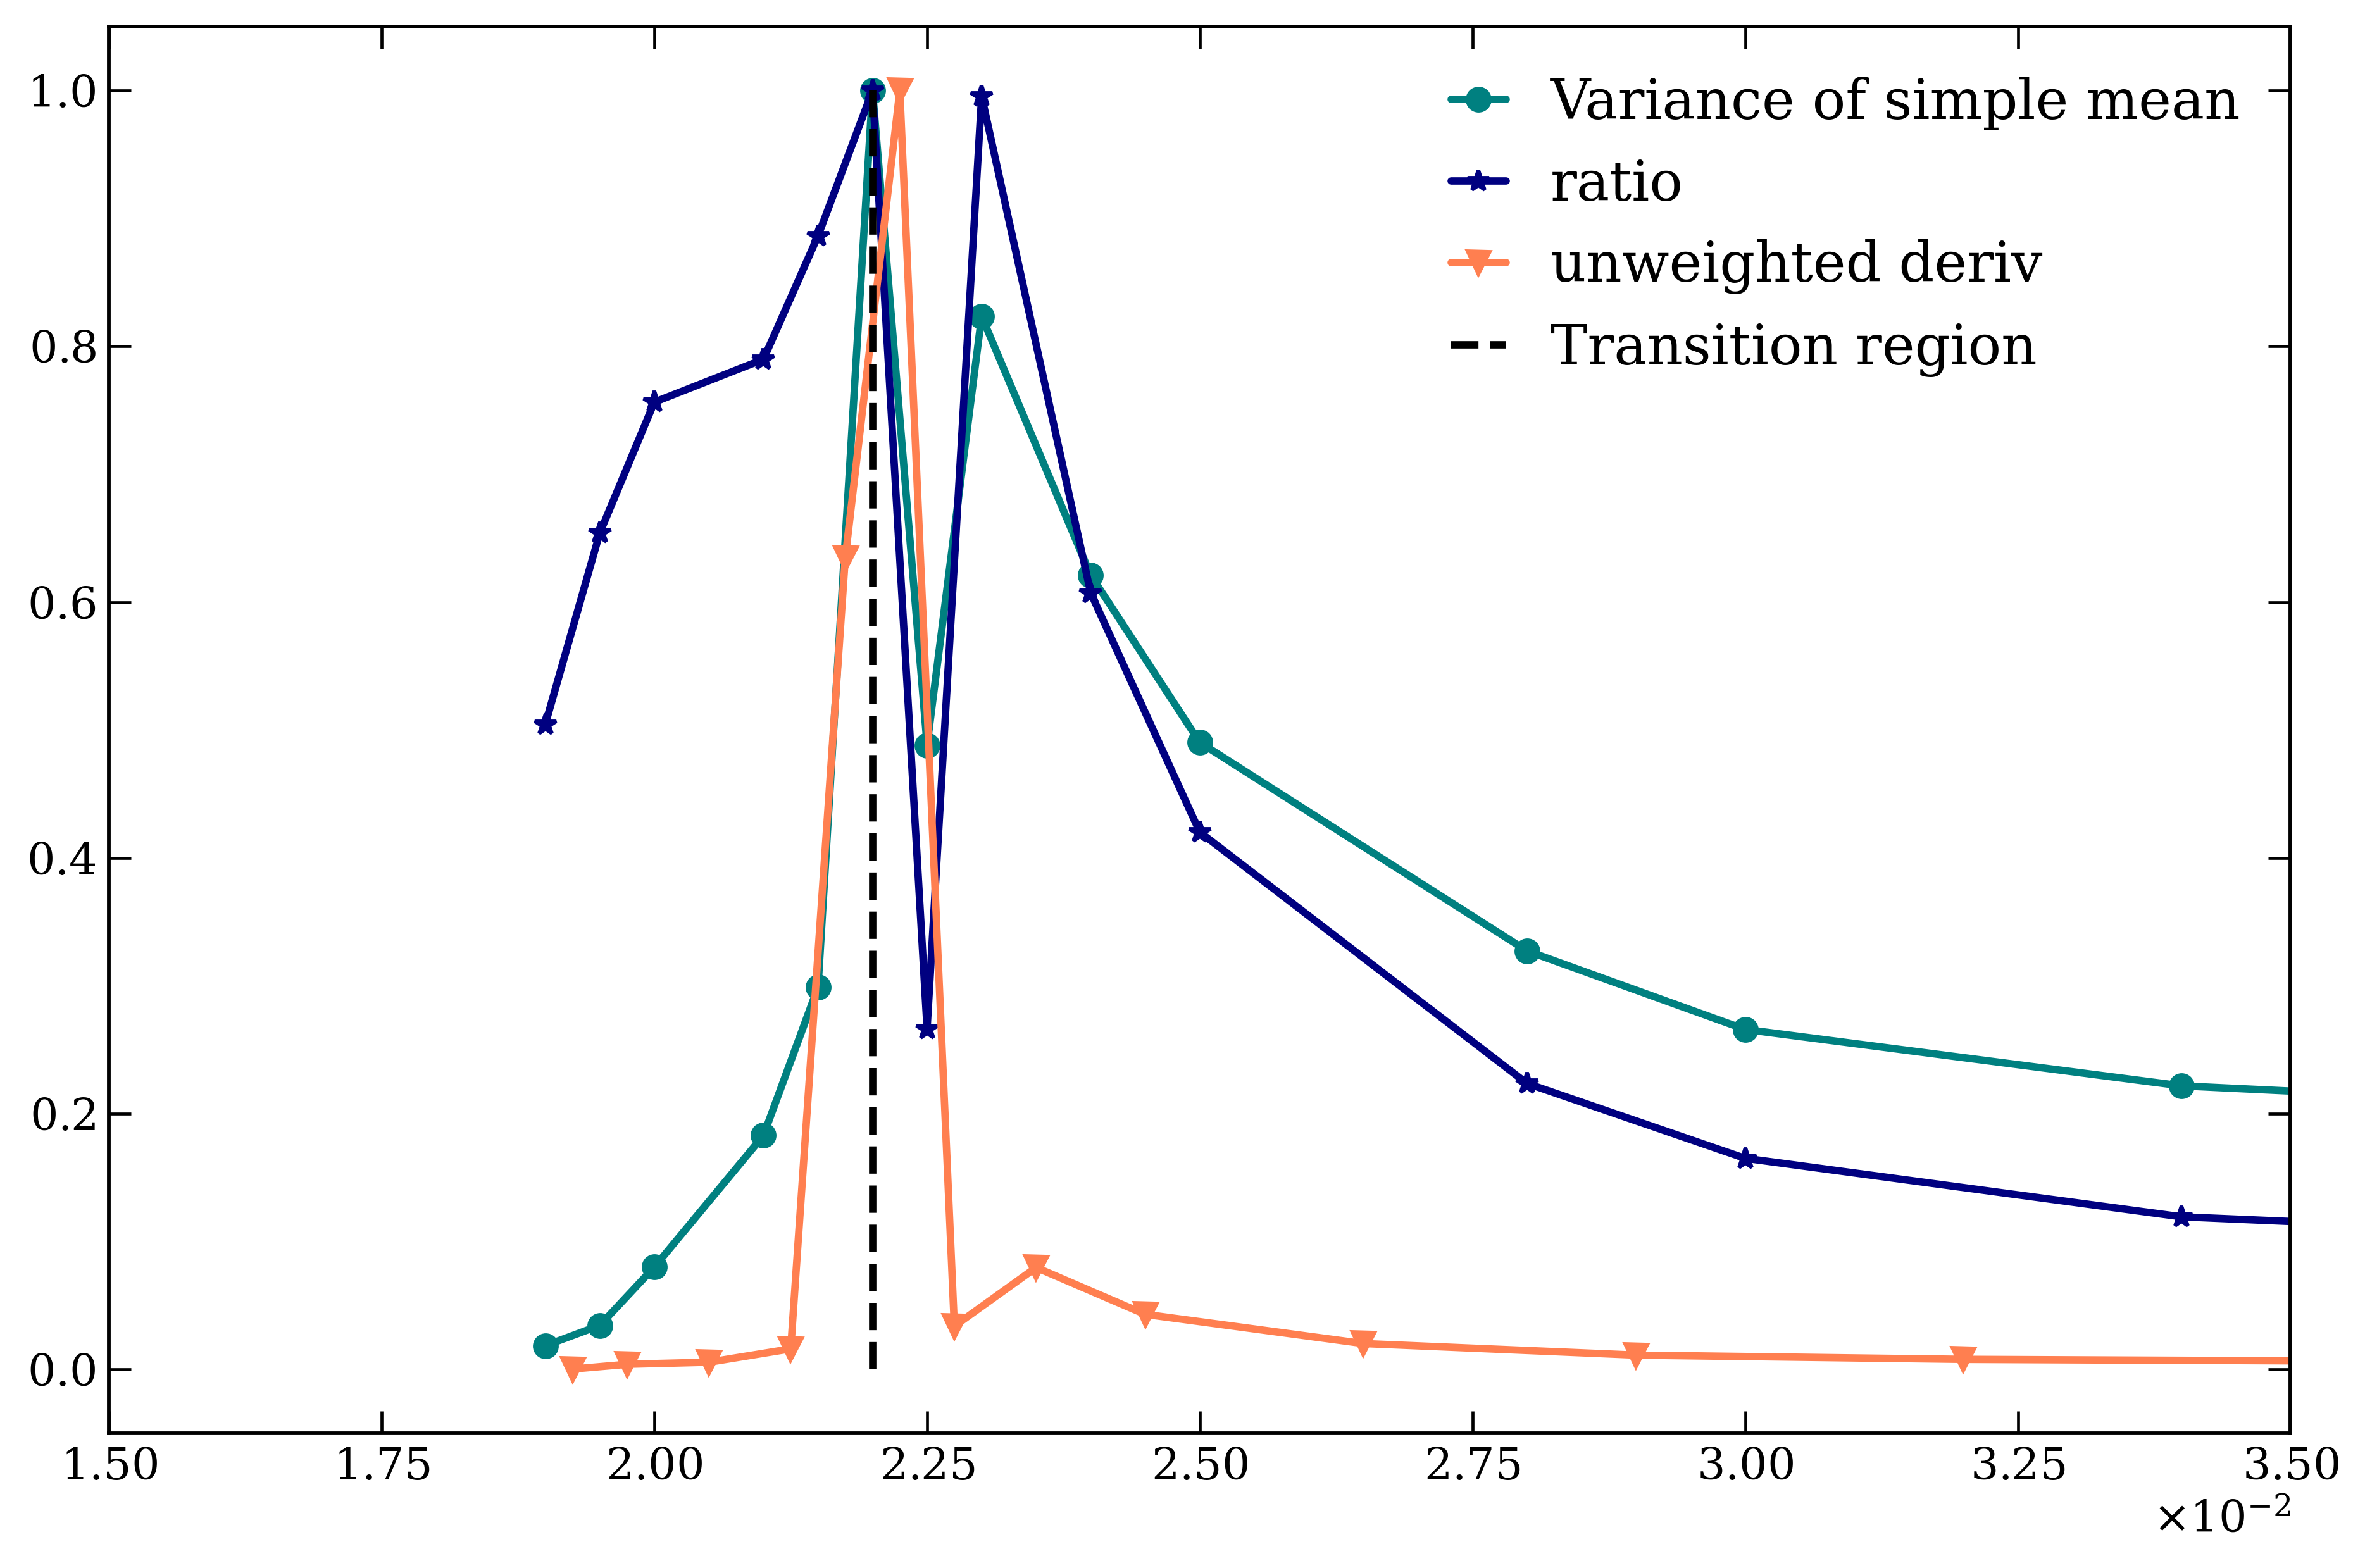

In [127]:
#plt.scatter(act_list, 1-np.mean(cid_frac_arr[:,:,0], axis=1))
plt.figure()
simp_var = np.nanvar(cid_arr[:,:,:,:,0], axis=(0,1,3))
simp_var /= np.nanmax(simp_var)
plt.plot(act_list, simp_var, label='Variance of simple mean', marker='o')
#plt.plot(act_list[:-1] + act_diff, deriv_cid_err[:]**2 / np.nanmax(deriv_cid_err[:]**2), marker='x', label='Variance of derivative')
#plt.plot(act_list[:-1] + act_diff, deriv_cidw_err[:]**2 / np.nanmax(deriv_cidw_err[:]**2), marker='s', label='Variance of weighted mean')
#plt.plot(act_list[:], frac_avw[:,1]**2 / np.nanmax(frac_avw[:-3,1]**2), marker='d', label='Variance of cid weighteed')
#plt.plot(act_list[:-1] + act_diff, deriv_cidw[:]**2 / np.nanmax(deriv_cidw[:]**2), marker='^', label='weighted deriv')
cid_var_ratio = cid_av[:,1]**2 / cid_av[:,0]

plt.plot(act_list[:], cid_var_ratio / np.nanmax(cid_var_ratio), marker='*', label='ratio') #Variance of cid unweighteed')
plt.plot(act_list[:-1] + act_diff/2, deriv_cid[:]**2 / np.nanmax(deriv_cid[:]**2), marker='v', label='unweighted deriv')
plt.xlim(0.015,0.035)
plt.vlines(0.022,0,1,color='k', linestyle='--', label='Transition region')
plt.legend()

In [ ]:
plt.imshow(frac_tav[:,3,0].reshape(4,4), #vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,4,0,4]   
        )

array([0.0195, 0.02  , 0.0205, 0.021 , 0.0215, 0.022 , 0.0225, 0.023 ,
       0.0235, 0.024 , 0.0245, 0.025 , 0.0255, 0.026 , 0.027 , 0.028 ,
       0.029 , 0.03  , 0.032 , 0.034 , 0.04  , 0.05  , 0.06  , 0.07  ,
       0.08  , 0.09  , 0.1   , 0.15  , 0.2   ])

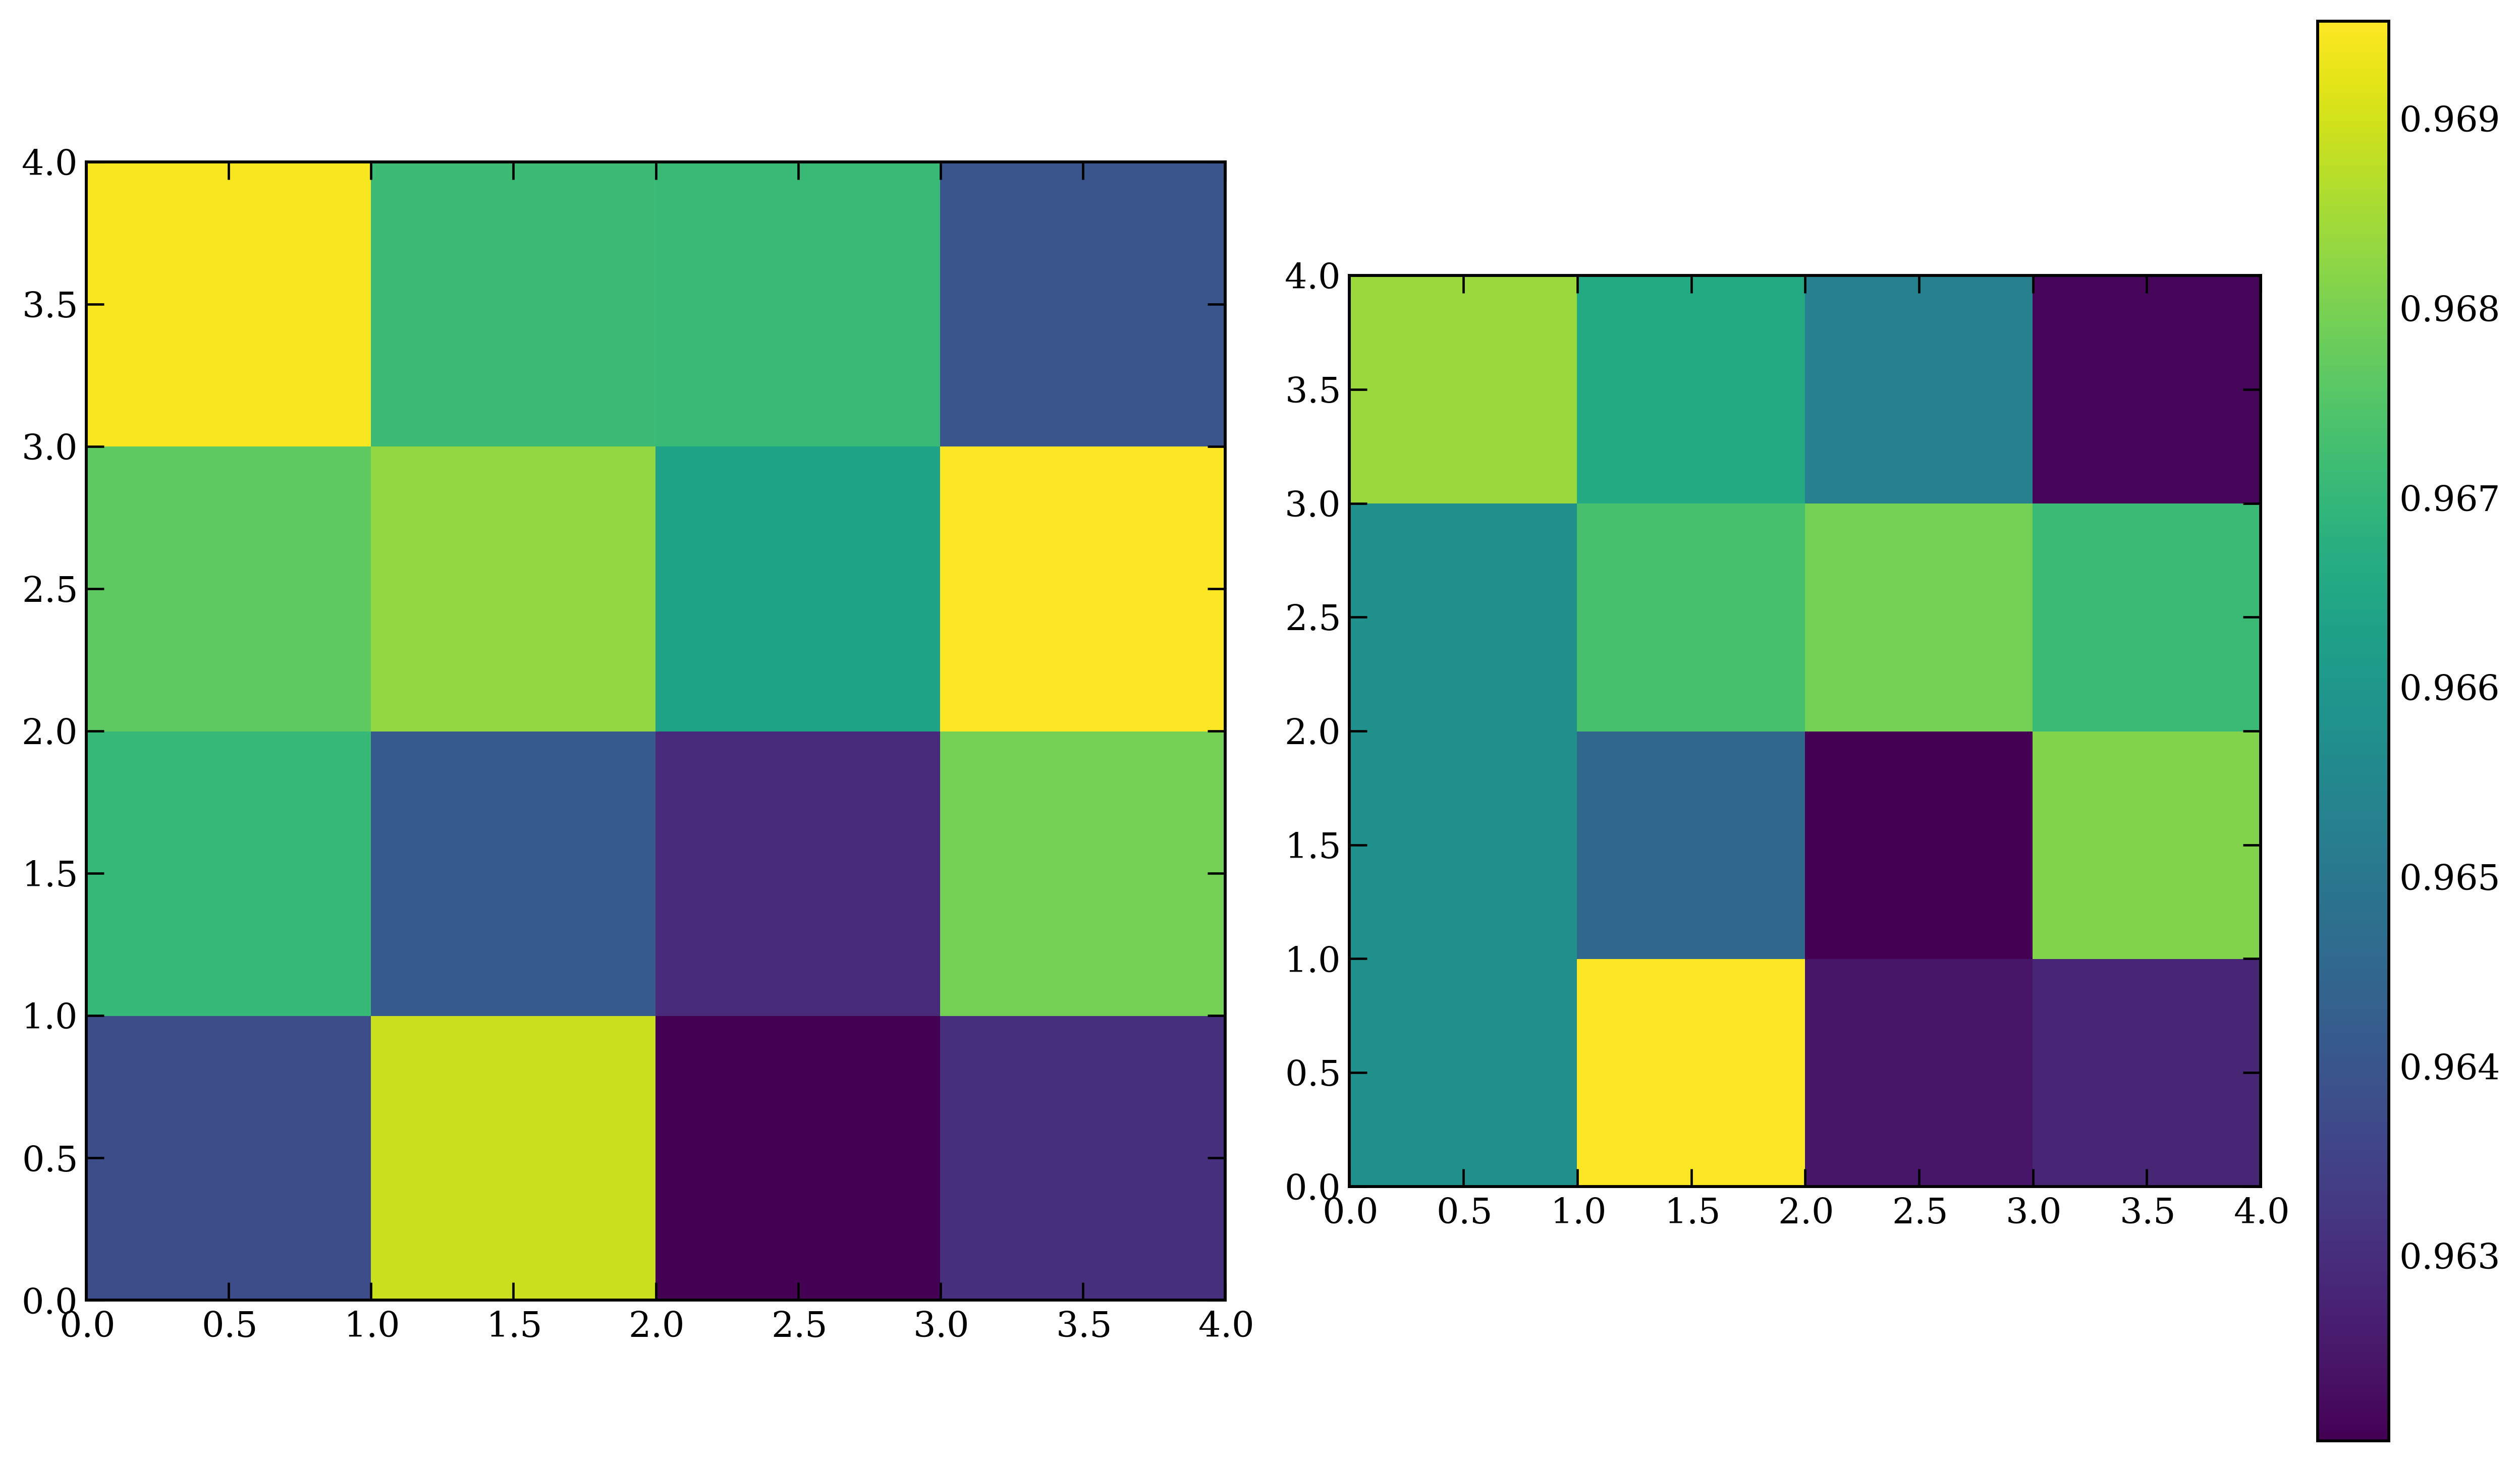

In [94]:
nboxes_per_side = int(np.sqrt(npartitions))
vmin, vmax = None, None
actidx = act_idx
fig, ax = plt.subplots(ncols=2,figsize=(12,7))
ax[0].imshow(frac_tav[:,actidx,0].reshape(nboxes_per_side,nboxes_per_side), vmin=vmin, vmax=vmax,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,nboxes_per_side,0,nboxes_per_side]   
        )
ax[1].imshow(frac_tavw[:,actidx,0].reshape(nboxes_per_side,nboxes_per_side), vmin=vmin, vmax=vmax,#vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,nboxes_per_side,0,nboxes_per_side]  ) 
#fig.colorbar(ax[0].images[0], ax=ax[0], label='CID / CID shuffle')
fig.colorbar(ax[1].images[0], ax=ax[1],)# label='CID / CID shuffle')

In [ ]:
nboxes_per_side = int(np.sqrt(npartitions))
plt.imshow(frac_tavw[:,act_idx,0].reshape(nboxes_per_side,nboxes_per_side), #vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,nboxes_per_side,0,nboxes_per_side]   
        )
plt.colorbar(label='CID / CID shuffle')


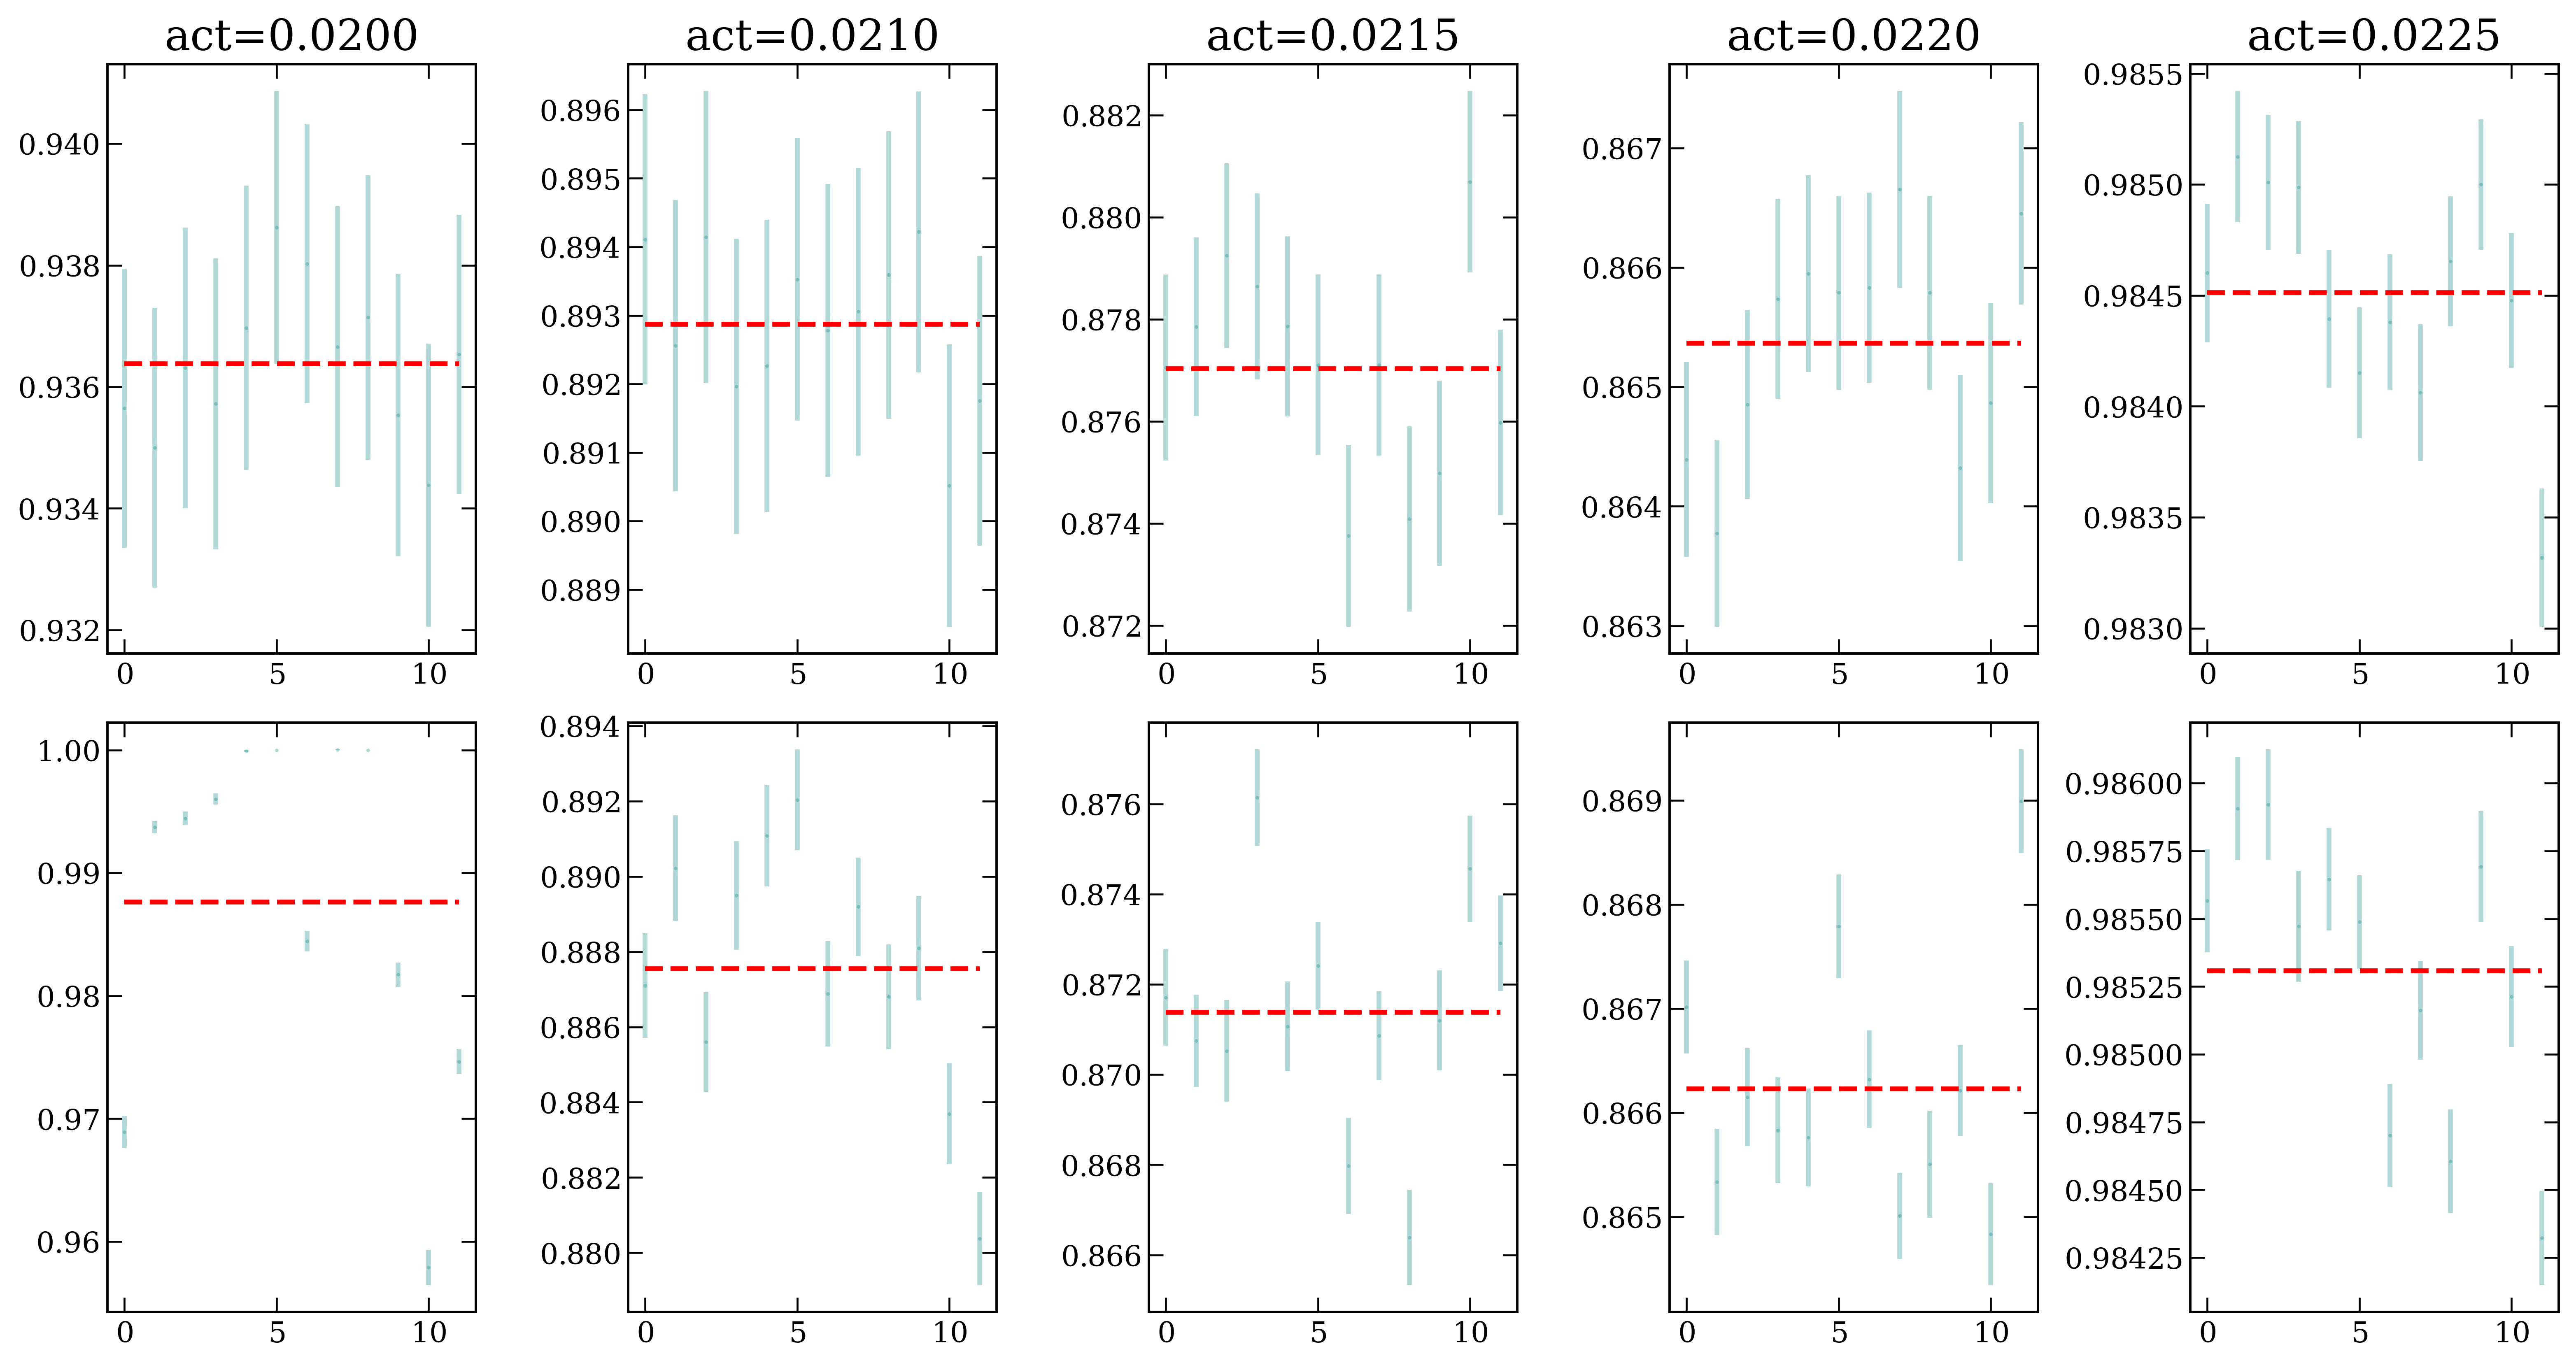

In [25]:
# plot mean and std of cid_arr, cid_shuffle_arr, cid_frac_arr over nexp for each act
ncols=5
actidx_min=2
fig, ax = plt.subplots(nrows=2,ncols=ncols,figsize=(15,8))
for j, act in enumerate(act_list[actidx_min:actidx_min+ncols]):
    i = j + actidx_min
    ax[0, j].errorbar(np.arange(ncubes), frac_sav[:,i,0], yerr=frac_sav[:,i,1], fmt='.', label=f'act={act}',alpha=.3,ms=1)
    ax[0, j].hlines(np.nanmean(frac_sav[:,i,0]), 0, ncubes-1, colors='r', linestyles='--', label='mean last 10')
    ax[0, j].set_title(f'act={act:.4f}')
    ax[1, j].errorbar(np.arange(ncubes), frac_savw[:,i,0], yerr=frac_savw[:,i,1], fmt='.', label=f'act={act}',alpha=.3,ms=1)
    ax[1, j].hlines(np.nanmean(frac_savw[:,i,0]), 0, ncubes-1, colors='r', linestyles='--', label='mean last 10')
   #ax[1,i].set_title(f'act={act:.4f}')
                                                                   

In [ ]:
act_expanded = np.repeat(np.array(act_list)[None,:], npartitions, axis=0)
act_expanded = np.repeat(act_expanded[None,:,:], ncubes, axis=0)
act_expanded = np.repeat(act_expanded[:,:,:,None], nexp, axis=2)
plt.scatter(act_expanded, cid_frac_arr[:,:,:,:,0], marker='.', alpha=0.1)
plt.ylim(.6,1.1)
plt.xscale('log')

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_6376\2465456290.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  simp_var = np.nanvar(cid_frac_arr[:,:,:,:,0], axis=(0,1,3))


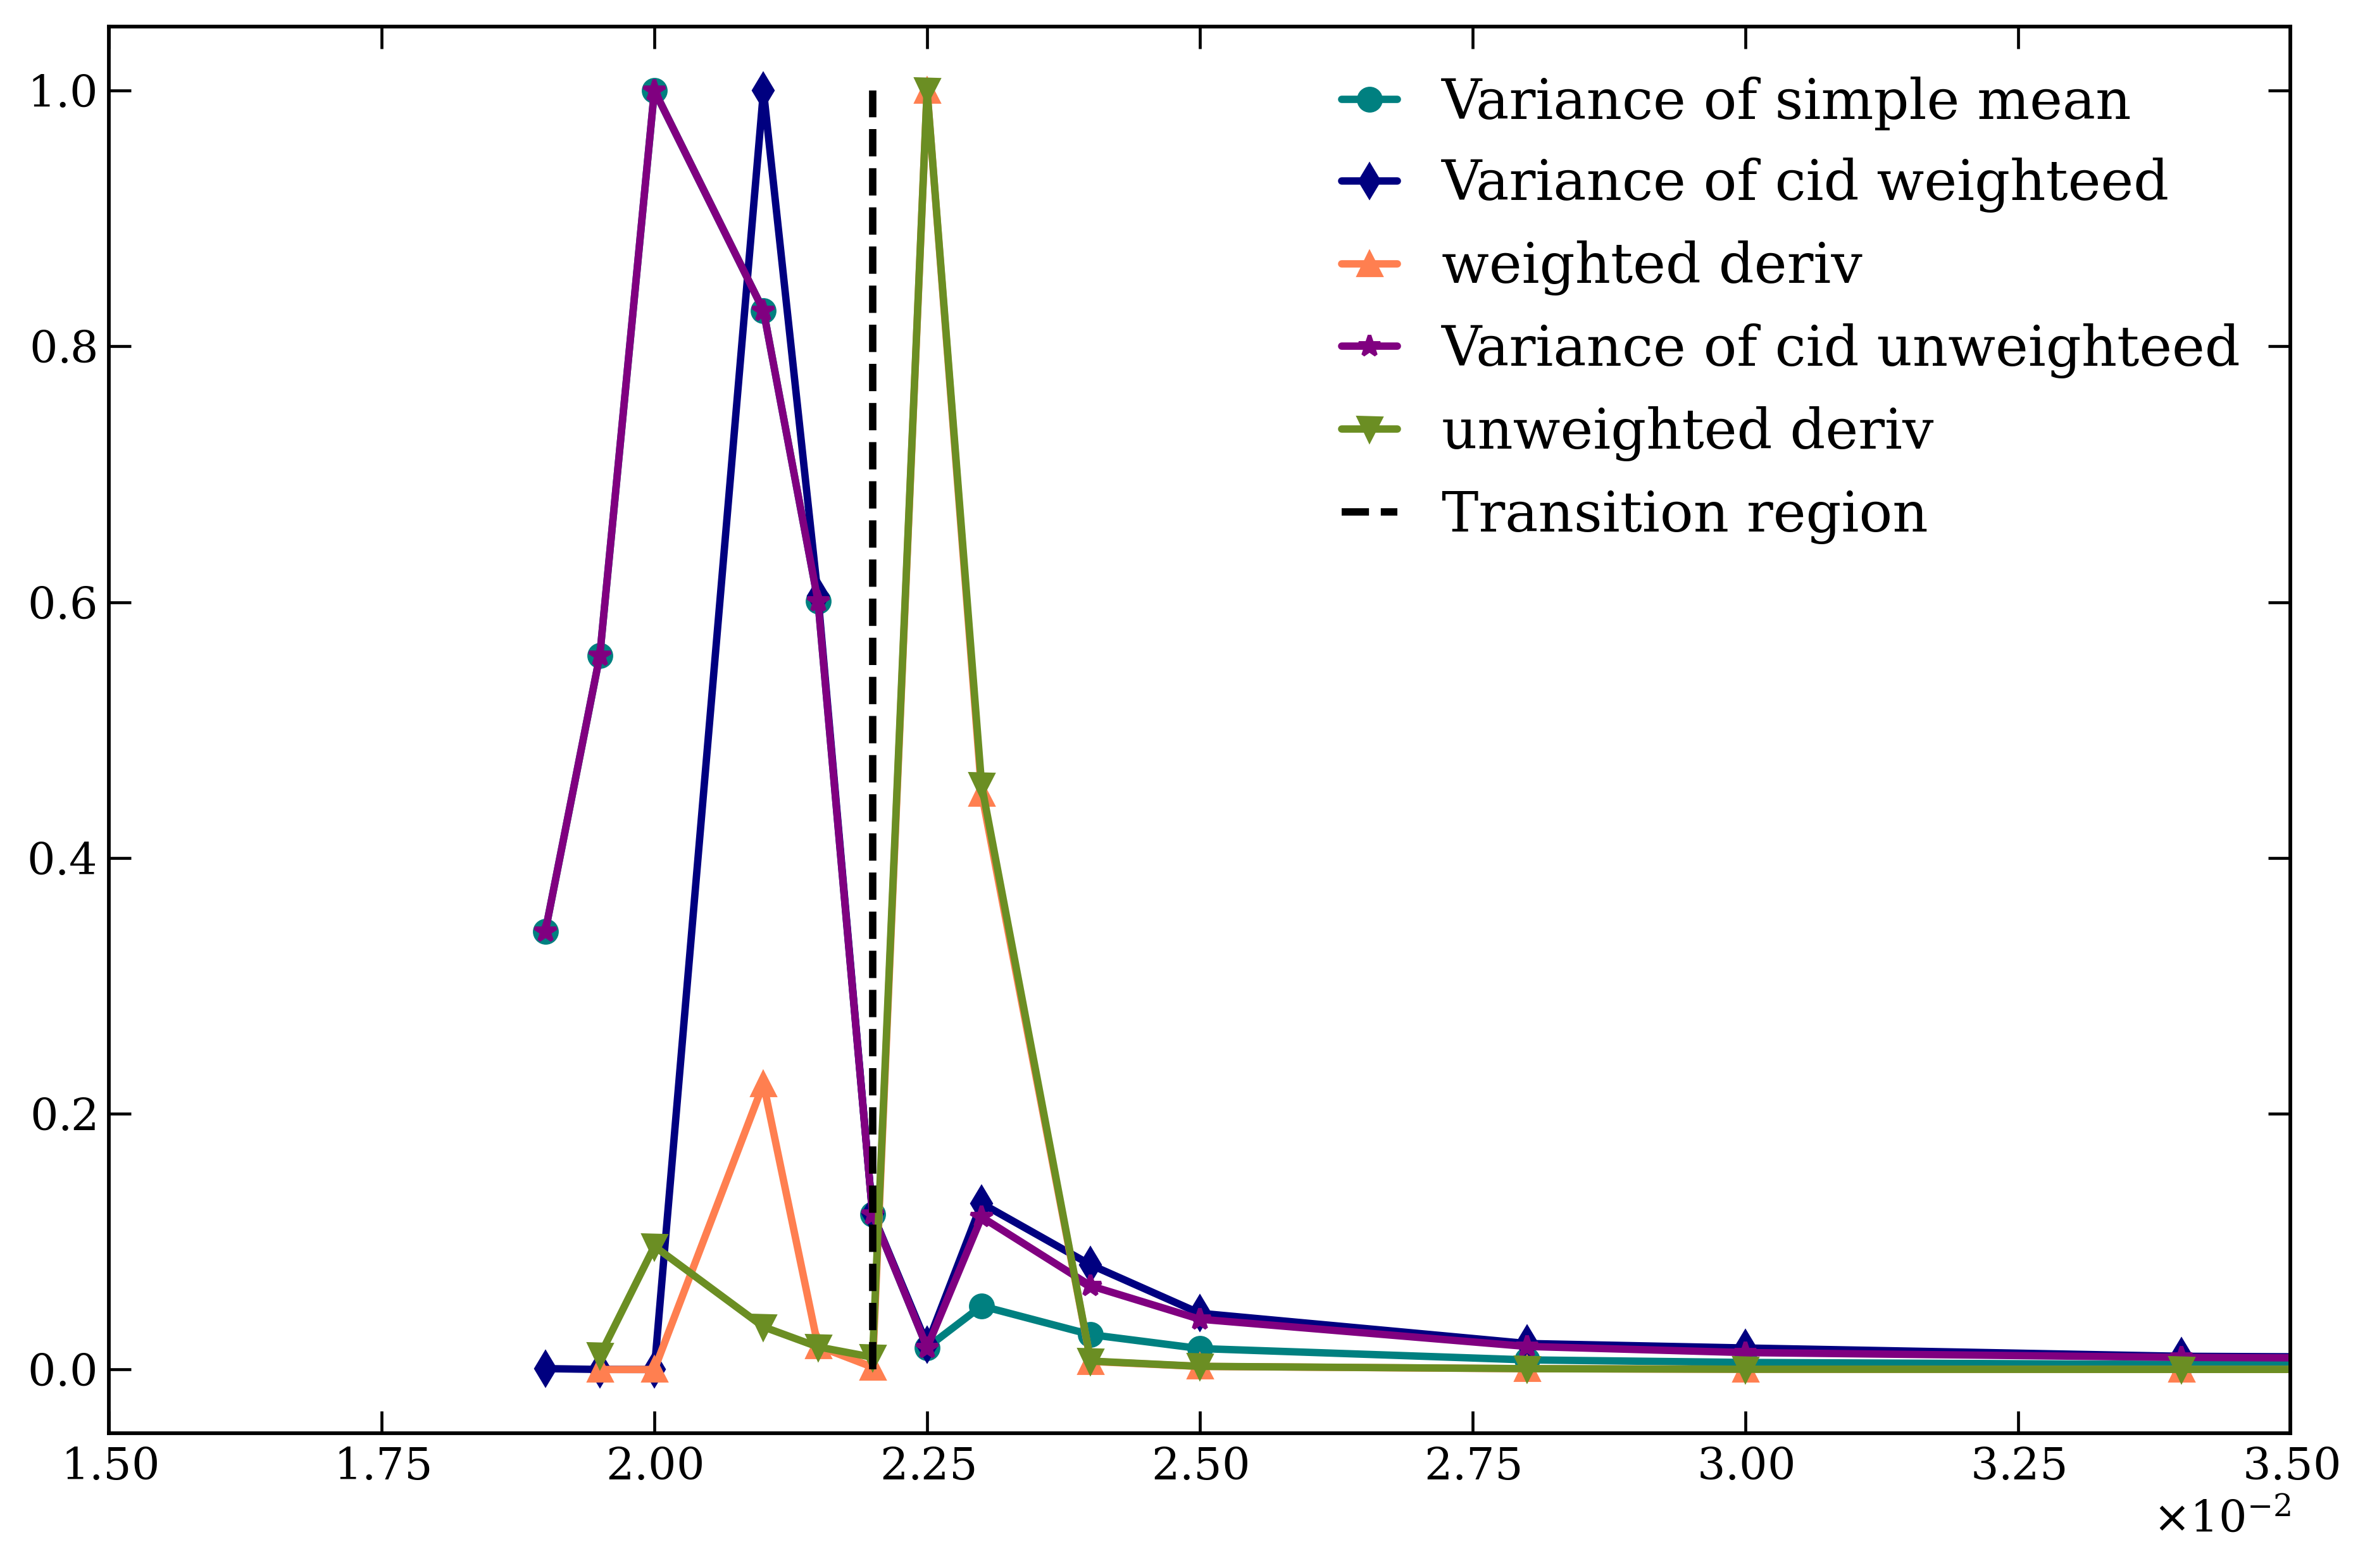

In [ ]:
#plt.scatter(act_list, 1-np.mean(cid_frac_arr[:,:,0], axis=1))
plt.figure()
simp_var = np.nanvar(cid_frac_arr[:,:,:,:,0], axis=(0,1,3))
simp_var /= np.nanmax(simp_var)
plt.plot(act_list, simp_var, label='Variance of simple mean', marker='o')
#plt.plot(act_list[:-1] + act_diff, deriv_cid_err[:]**2 / np.nanmax(deriv_cid_err[:]**2), marker='x', label='Variance of derivative')
#plt.plot(act_list[:-1] + act_diff, deriv_cidw_err[:]**2 / np.nanmax(deriv_cidw_err[:]**2), marker='s', label='Variance of weighted mean')
plt.plot(act_list[:], frac_avw[:,1]**2 / np.nanmax(frac_avw[:,1]**2), marker='d', label='Variance of cid weighteed')
plt.plot(act_list[:-1] + act_diff, deriv_cidw[:]**2 / np.nanmax(deriv_cidw[:]**2), marker='^', label='weighted deriv')
plt.plot(act_list[:], frac_av[:,1]**2 / np.nanmax(frac_av[:,1]**2), marker='*', label='Variance of cid unweighteed')
plt.plot(act_list[:-1] + act_diff, deriv_cid[:]**2 / np.nanmax(deriv_cid[:]**2), marker='v', label='unweighted deriv')
plt.xlim(0.015,0.035)
plt.vlines(0.022,0,1,color='k', linestyle='--', label='Transition region')
plt.legend()